<a href="https://colab.research.google.com/github/pachterlab/CBP_2022/blob/main/notebooks/VMHNeurons/kimetal_tenx_bmcml_linDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import os


from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2065','.gz')

#tenx.mtx (log counts)
download_file('10.22002/D1.2072','.gz')

#var.csv
download_file('10.22002/D1.2066','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2065 metadata.csv")
os.system("mv D1.2072 tenx.mtx")
os.system("mv D1.2066 var.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/940 [00:00<?, ?B/s]

  0%|          | 0/104912 [00:00<?, ?B/s]

  0%|          | 0/12 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 145 (delta 78), reused 100 (delta 45), pack-reused 0
Receiving objects: 100% (145/145), 410.98 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CBP_2022.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 372 (delta 216), reused 91 (delta 25), pack-reused 0
Receiving objects: 100% (372/372), 52.53 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [ ]:
%cd /content/CBP_2022/scripts

/content/CBP_2021/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.6.0
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 8.4 MB/s 
     |████████████████████████████████| 7.7 MB 7.9 MB/s 
     |████████████████████████████████| 80 kB 12.4 MB/s 
     |████████████████████████████████| 1.1 MB 68.7 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 


## **Install Packages**

In [ ]:
import anndata 
import pandas as pd
import numpy as np
from MCML import MCML, bMCML #Now has continuous label addition
import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')


## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

pcs = 50
n_latent = 50

In [ ]:
genes = pd.read_csv(data_path+'/var.csv')

In [ ]:
count_mat = sio.mmread(data_path+'/tenx.mtx')
count_mat.shape

(41580, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

sample_name  ... pass_mito_filter
0  10x_VMH_Female_Control_1  ...            False
1  10x_VMH_Female_Control_1  ...            False
2  10x_VMH_Female_Control_1  ...            False
3  10x_VMH_Female_Control_1  ...             True
4  10x_VMH_Female_Control_1  ...            False

[5 rows x 13 columns]

In [ ]:
meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1]

3.829829248460913

In [ ]:
meta.cluster.value_counts()

Nr5a1_4          3827
Dlk1_3           2317
Satb2_2          2132
Dlk1_4           2124
Dlk1_1           2046
Dlk1_2           1830
Nr5a1_1          1794
Tsix_Esr1_1      1659
Nr5a1_Foxp2_2    1571
Satb2_1          1567
Nr5a1_Foxp2_1    1500
Dlk1_5           1487
Esr1_2           1390
Esr1_1           1310
Dlk1_6           1304
Nr5a1_3          1223
Esr1_5           1210
Nup62cl          1201
Esr1_4           1070
Esr1_3           1059
Nr5a1_7          1050
Nr5a1_10         1041
Nr5a1_9          1018
Nr5a1_2          1003
Nr5a1_5          1002
Nr5a1_8           838
Satb2_3           798
Scgn              514
Esr1_6            500
Nr5a1_6           195
Name: cluster, dtype: int64

In [ ]:
lab1 = list(meta.cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.sample_name)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.cluster_color))

sex_colors = ['#F8C471','#abacb7']

Set Ambient Data

In [ ]:
amb = tl.getCentroidDists(count_mat,meta.cluster)
ambIntra = tl.getIntraVar(count_mat, meta.cluster, meta.sex_label)
ambIntraC = tl.getIntraVar(count_mat, meta.cluster, meta.cluster)
ambInter = tl.getInterVar(count_mat, meta.cluster, meta.sex_label)


In [ ]:
def getAllVars(latents,latentLab,latentType):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, meta.cluster)
    intra = tl.getIntraVar(i, meta.cluster, meta.sex_label)
    intraC = tl.getIntraVar(i, meta.cluster, meta.cluster)
    inter = tl.getInterVar(i, meta.cluster, meta.sex_label)

    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0], stats.pearsonr(intraC, ambIntraC)[0], stats.pearsonr(inter, ambInter)[0]]
    dist += ['Inter-Type','Intra-Sex','Intra-Type','Inter-Sex'] 

    emb += [l]*4
    dim += [d]*4


  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim


  return allVals


In [ ]:
# reducer = umap.UMAP(n_components = ndims, random_state = state)
# tsne = TSNE(n_components = ndims, random_state = state) 

### **PCA Test**

In [ ]:
#PCA 
tsvd = TruncatedSVD(n_components=pcs)
x_pca = tsvd.fit_transform(scaled_mat)

tsvd = TruncatedSVD(n_components=2)
x_pca_2d = tsvd.fit_transform(scaled_mat)

pcaUMAP = reducer.fit_transform(x_pca)

pcaTSNE = tsne.fit_transform(x_pca)

### **Linear Decoder Demonstration**

Run MCML (NCA cost function) with sex and cell type labels

In [ ]:
ncaNCA = MCML(n_latent = n_latent, epochs = 100) #n_latent

tic = time.perf_counter()
lossesNCA, latentNCA = ncaNCA.fit(scaled_mat,allLabs,fracNCA = 0.25, silent = True,ret_loss = True)
toc = time.perf_counter()
print(f"nnNCA fit in {toc - tic:0.4f} seconds")



nnNCA fit in 570.7615 seconds


Get weights for each gene (input feature) for each node in the decoder layer (n nodes where n is dimension of latent space)

In [ ]:
weight_loadings = ncaNCA.getLoadings()

print(weight_loadings.shape)
genes_names = genes.gene_name


(1999, 50)


For first 10 dimensions, plot coordinates of labeled cells and genes

In [ ]:
!mkdir figs

mkdir: cannot create directory ‘figs’: File exists


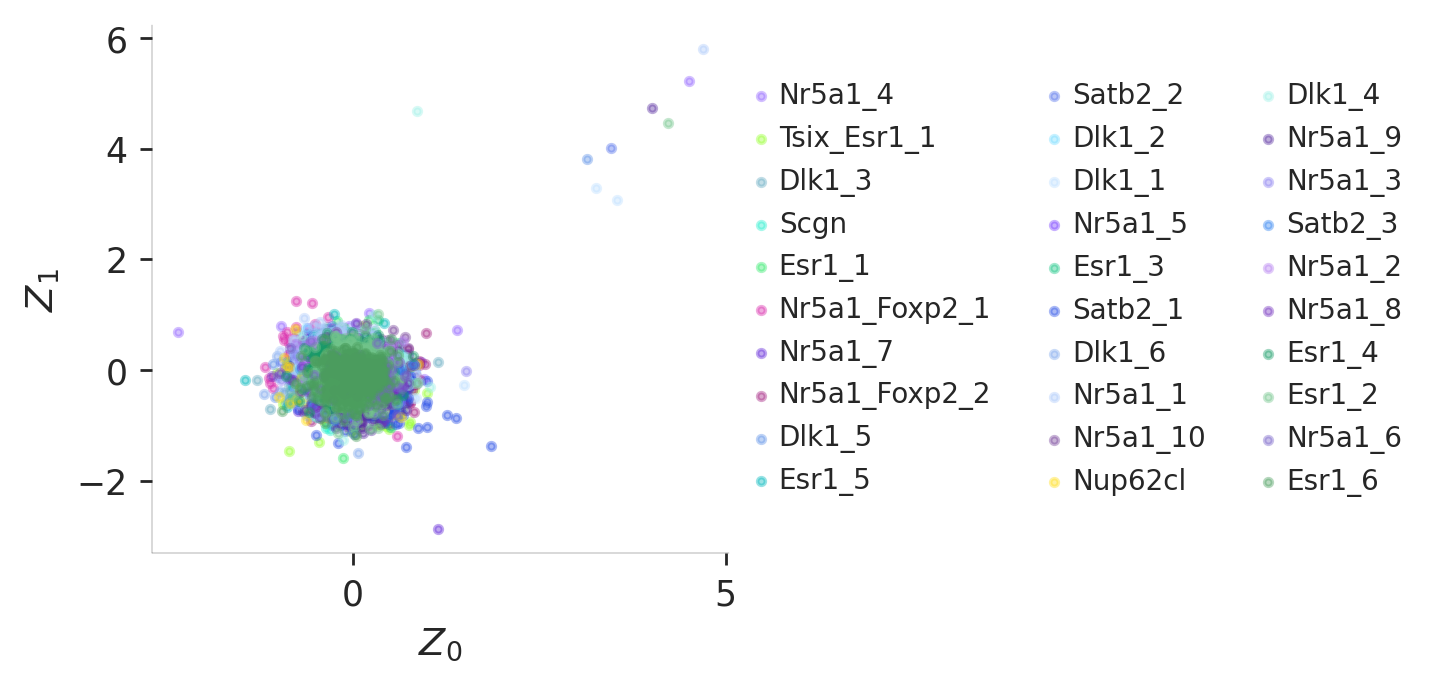

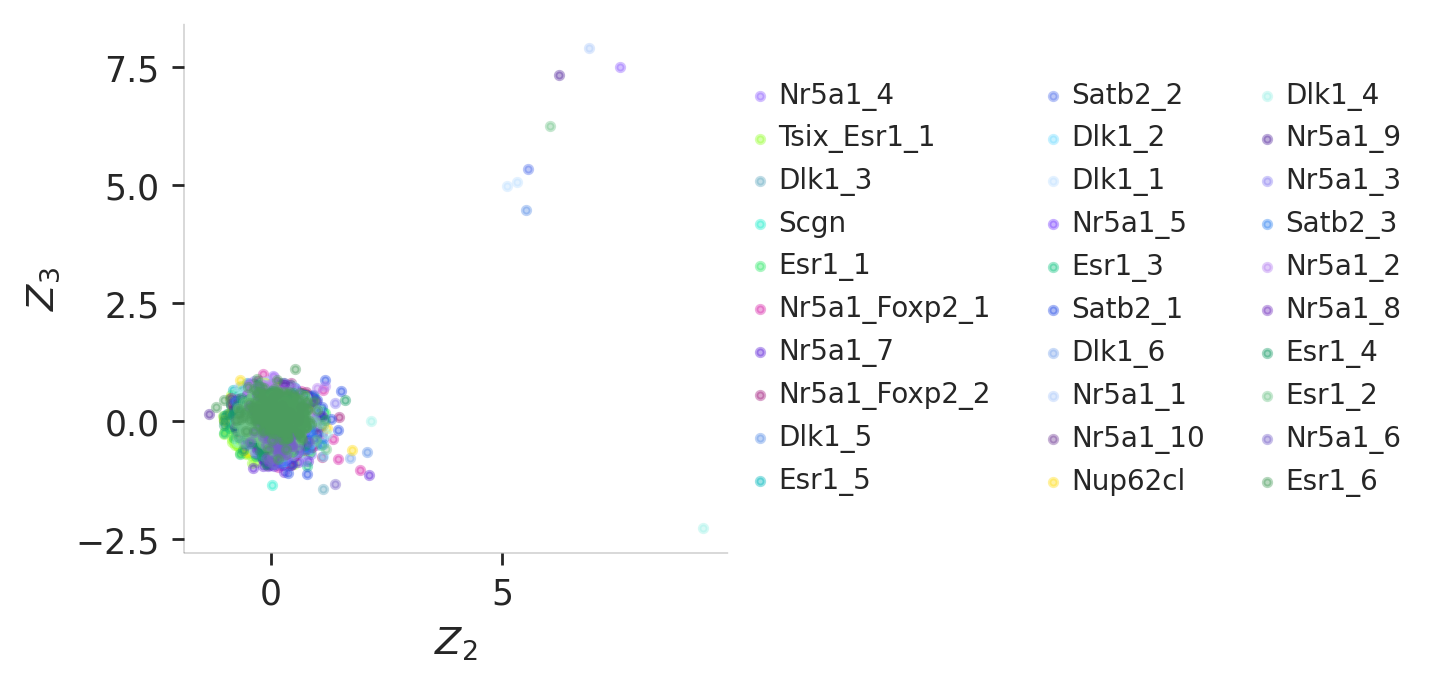

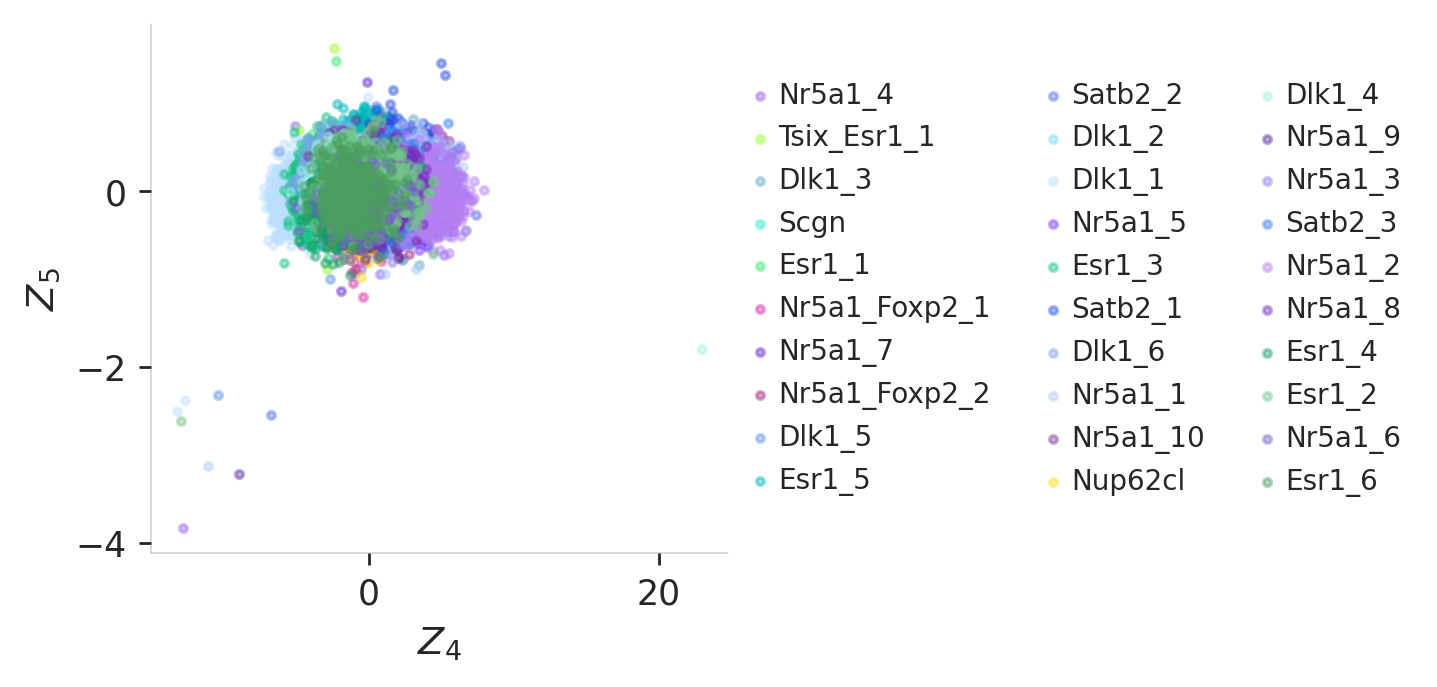

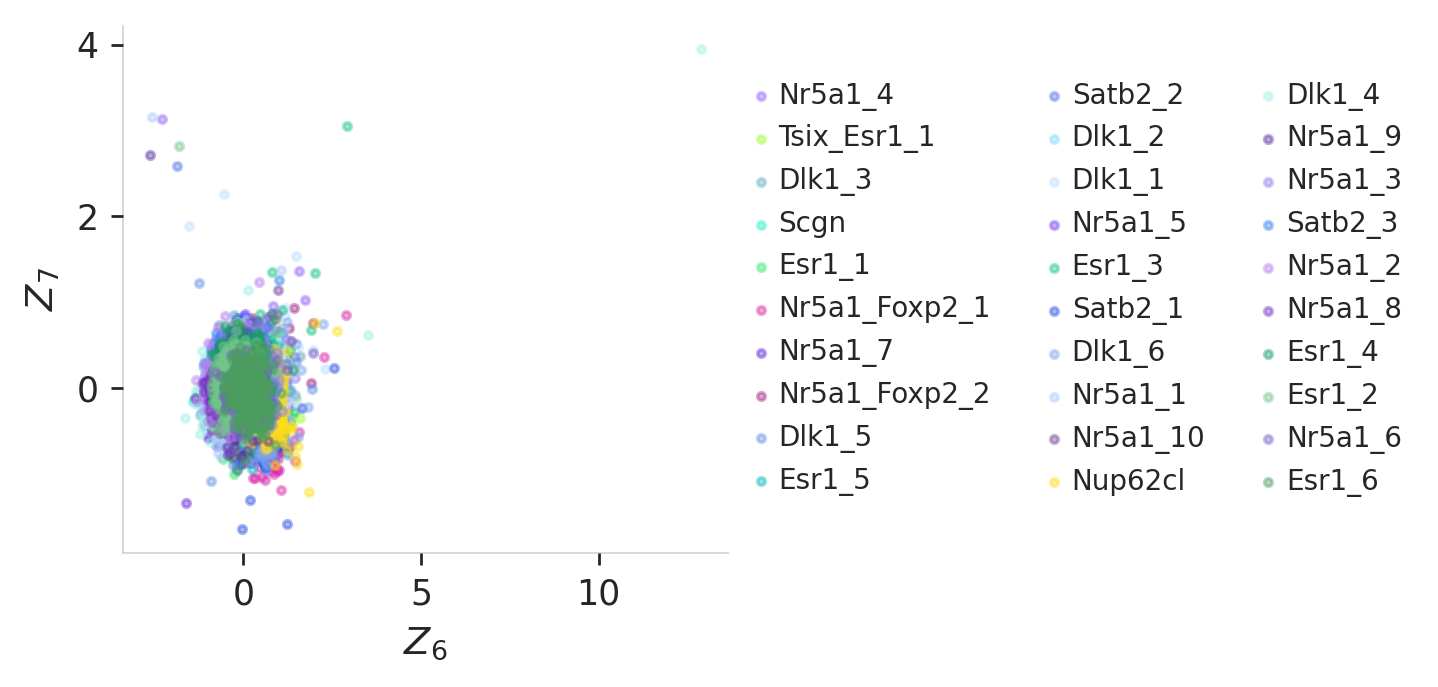

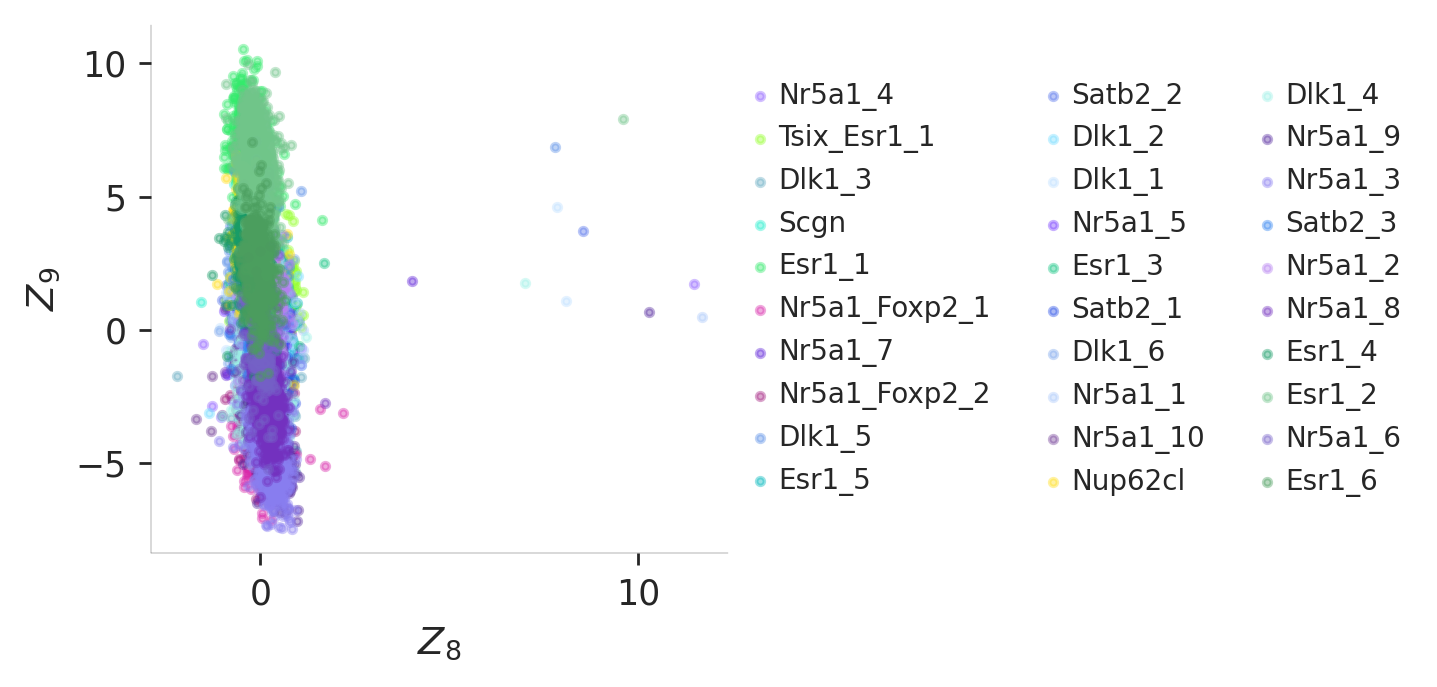

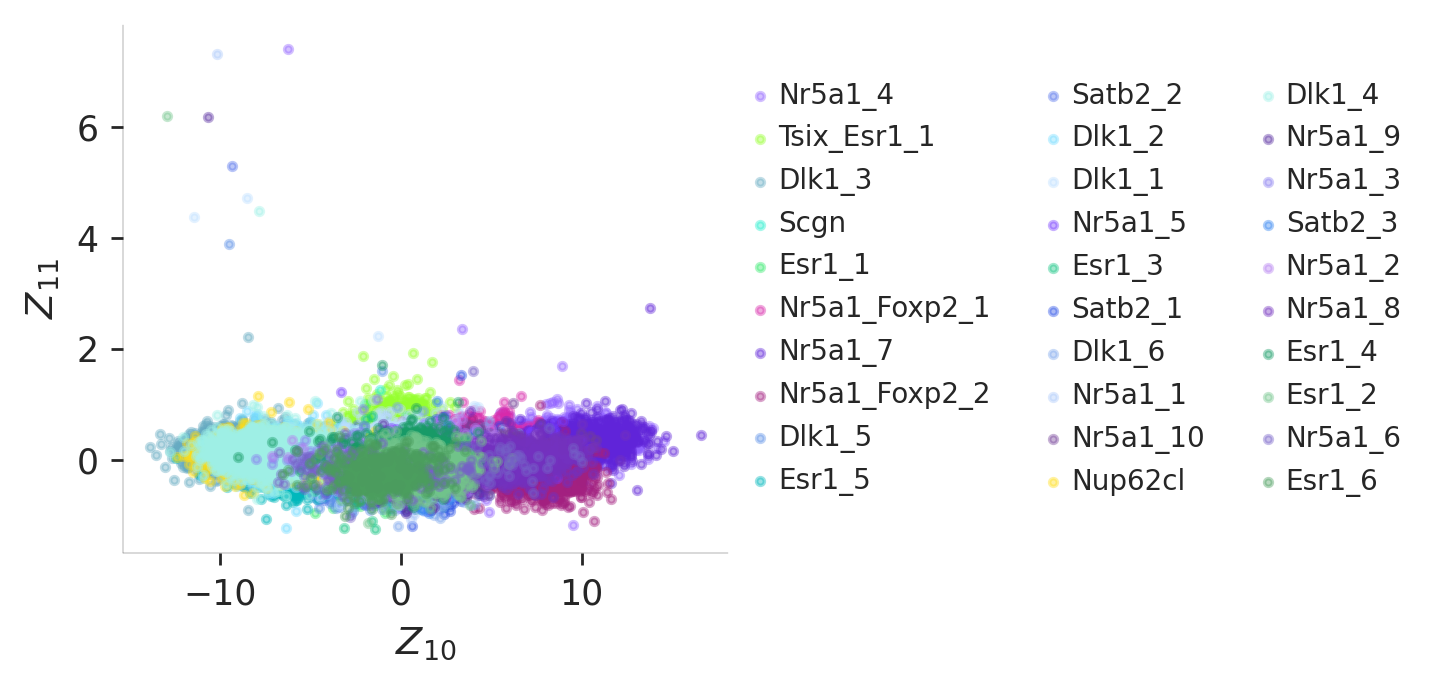

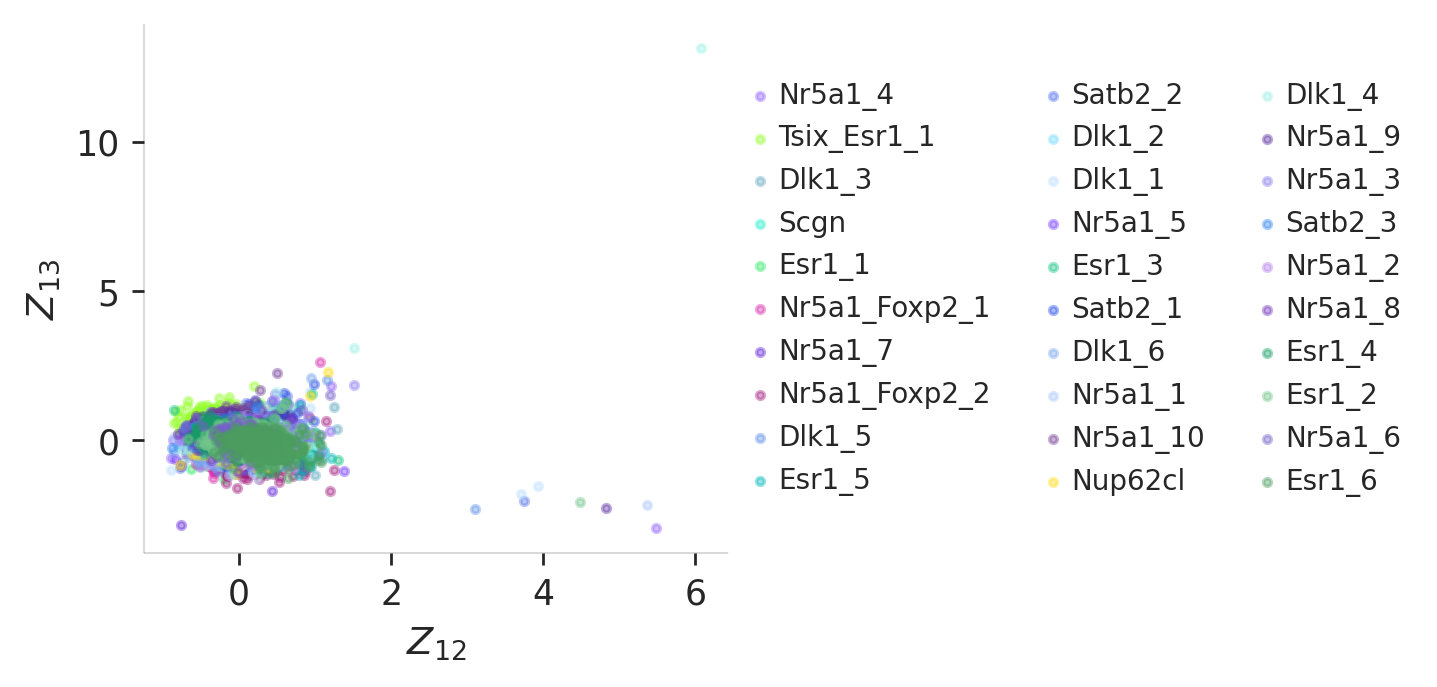

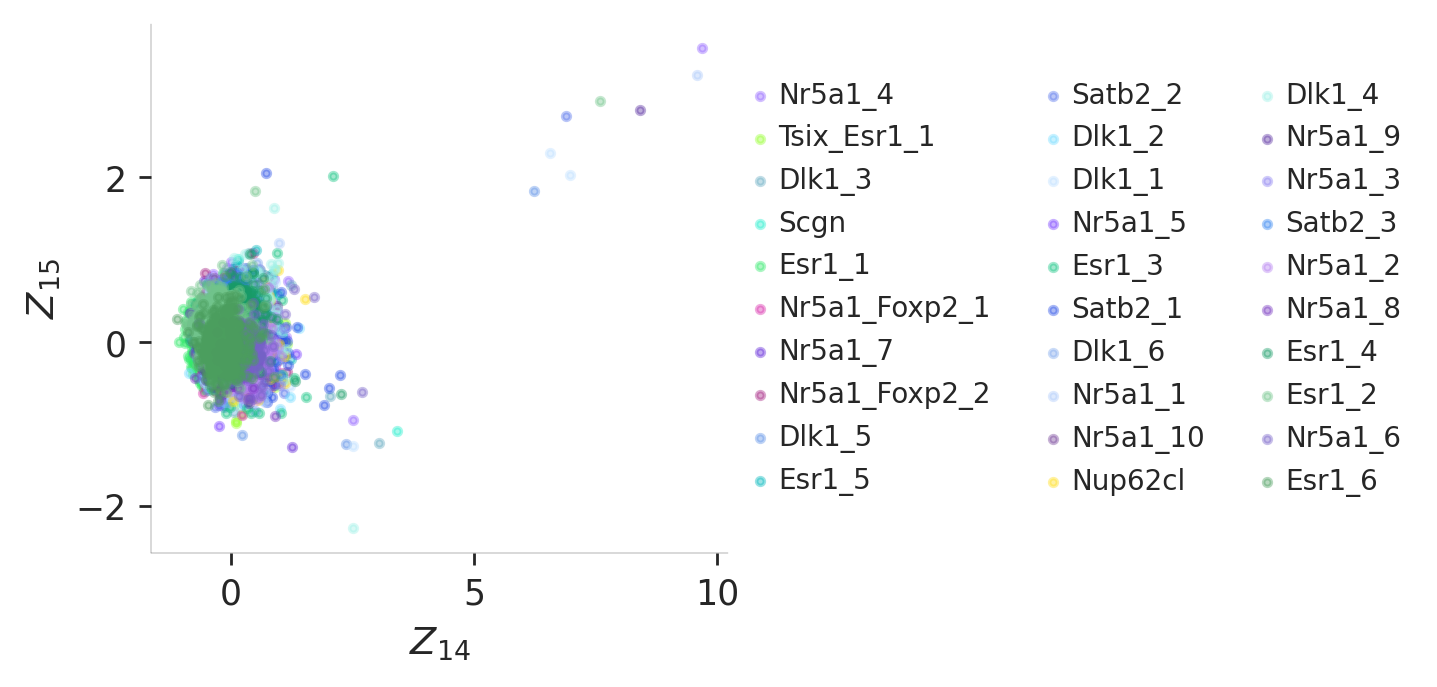

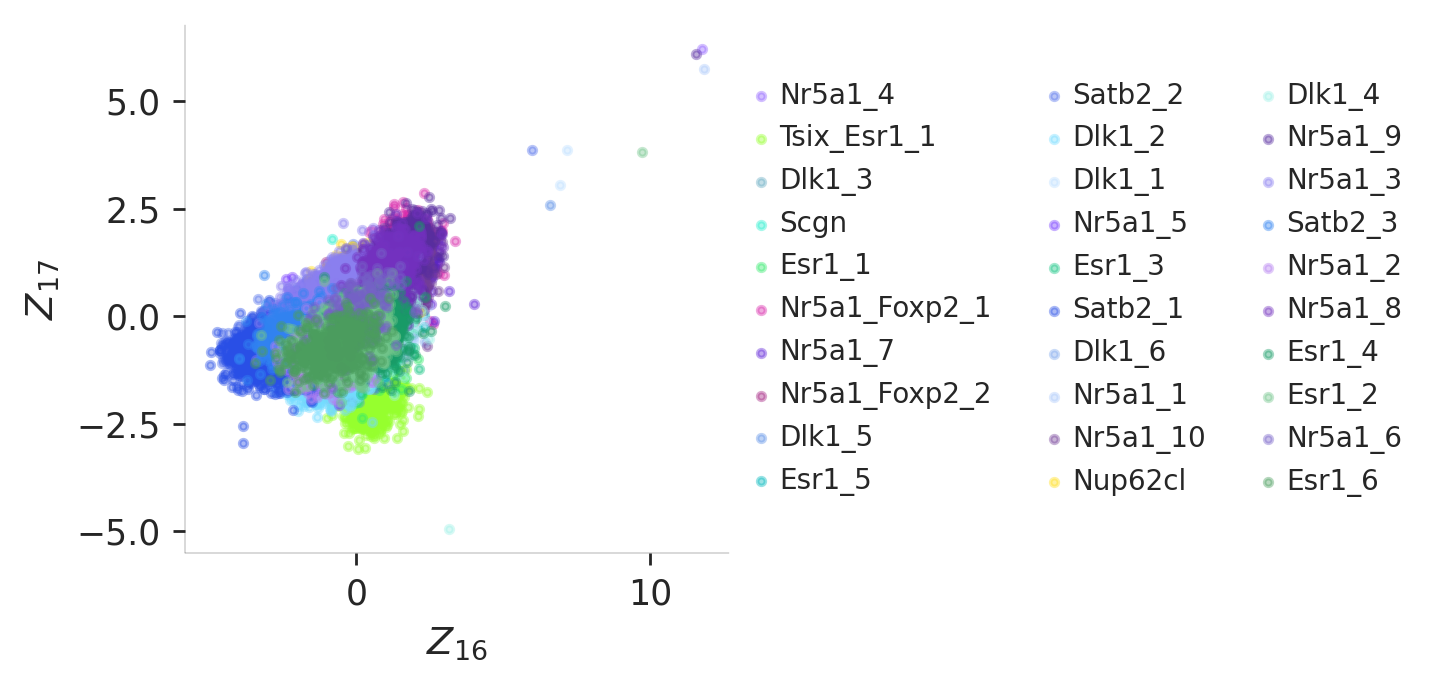

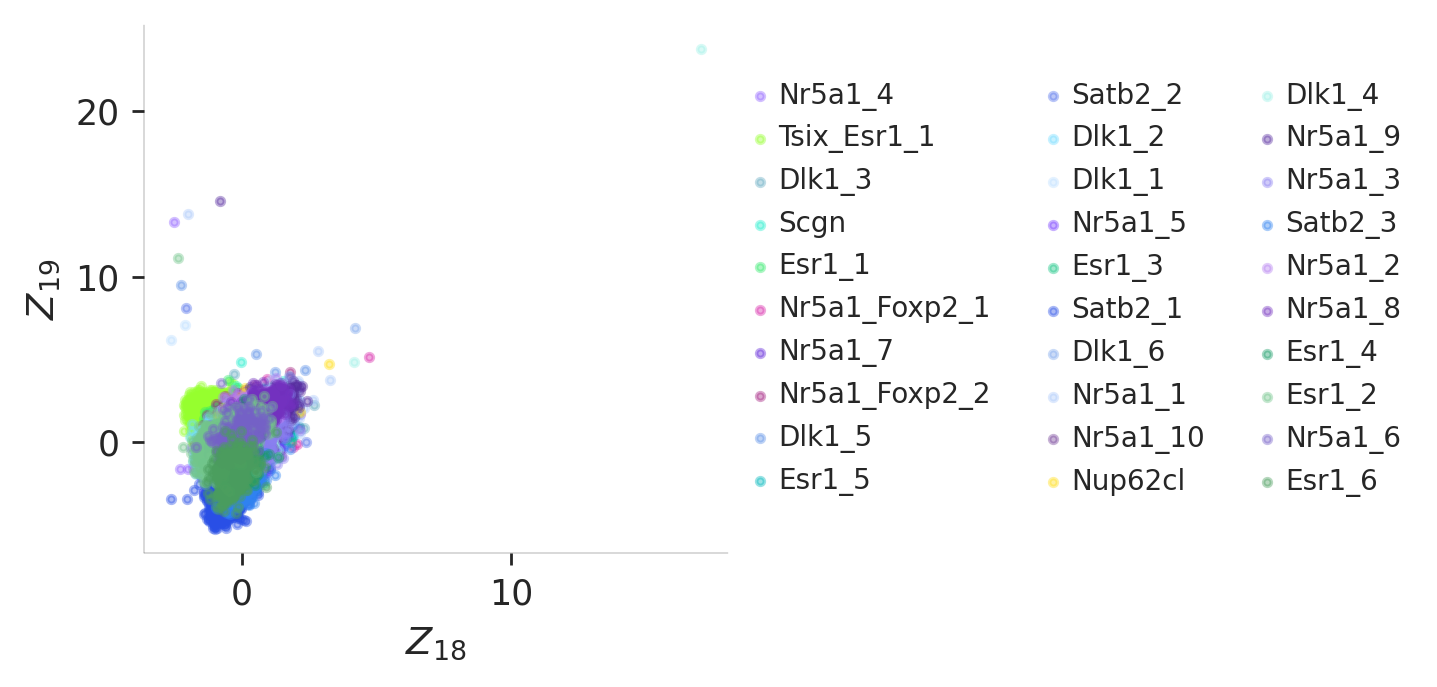

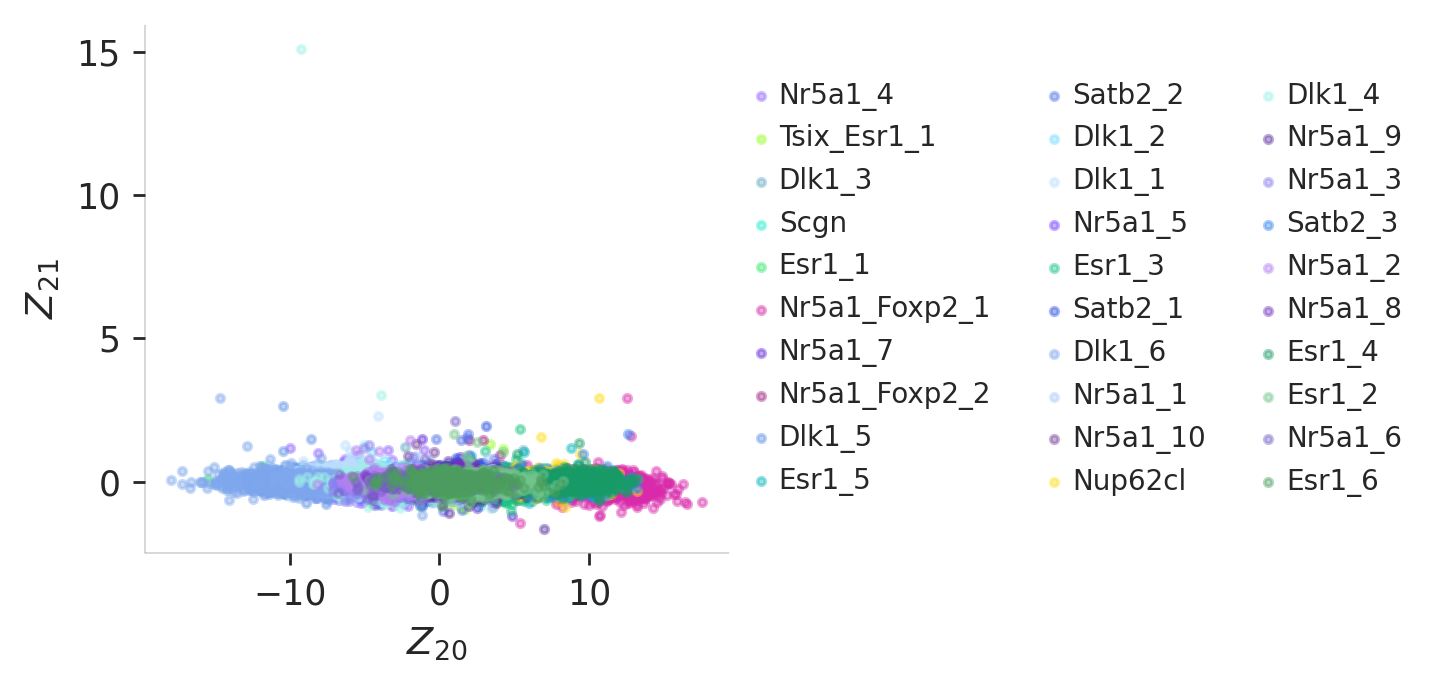

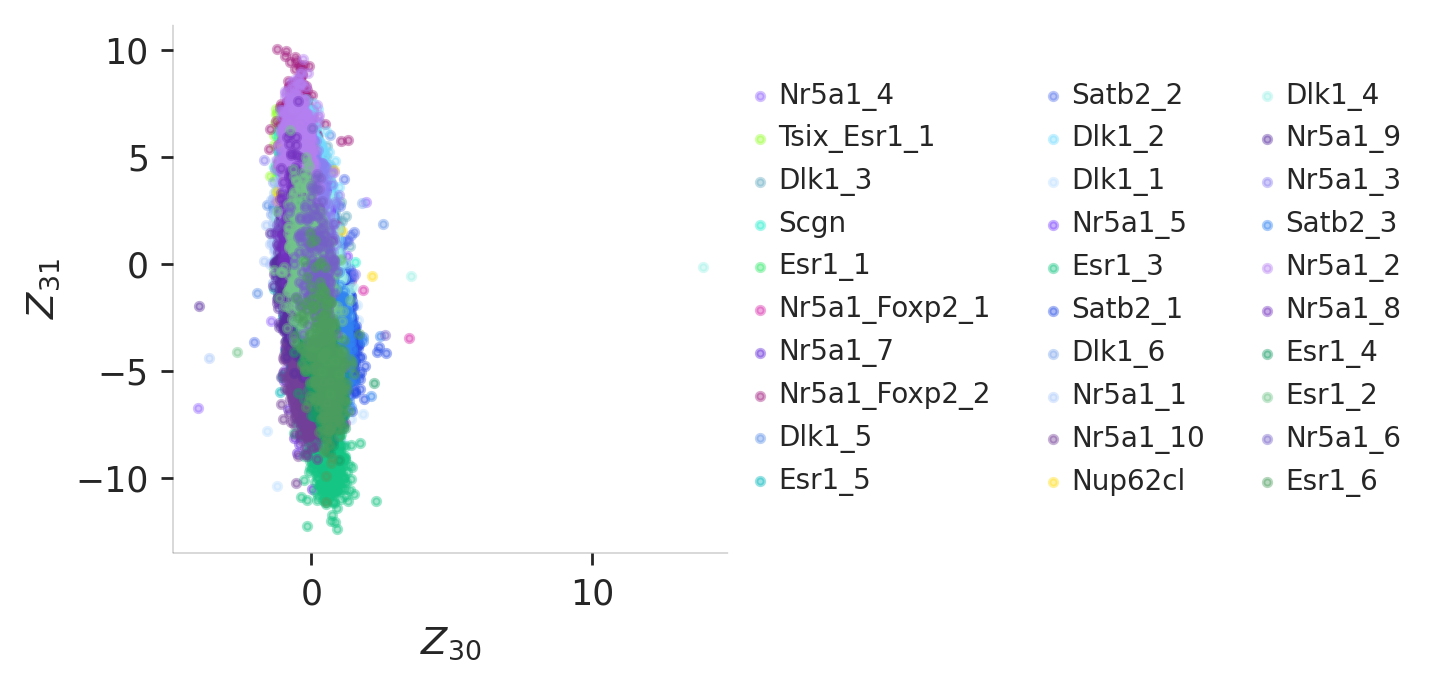

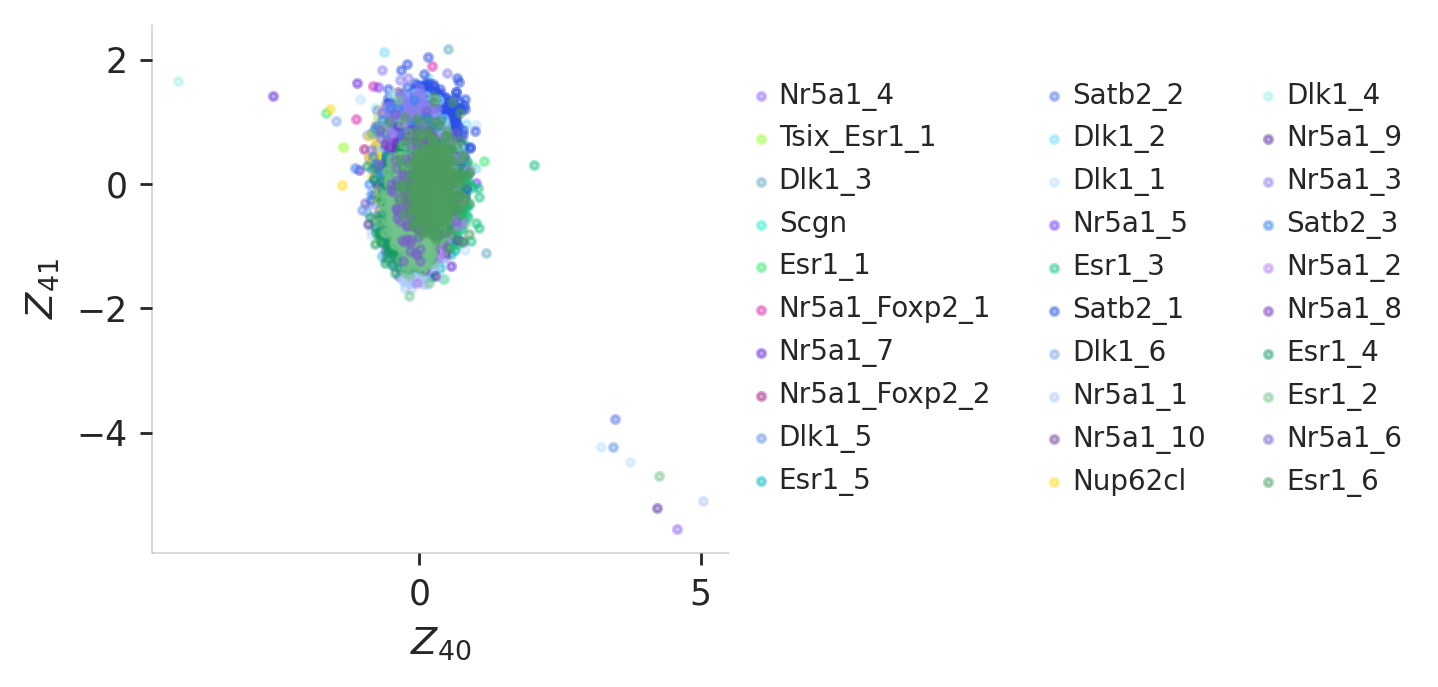

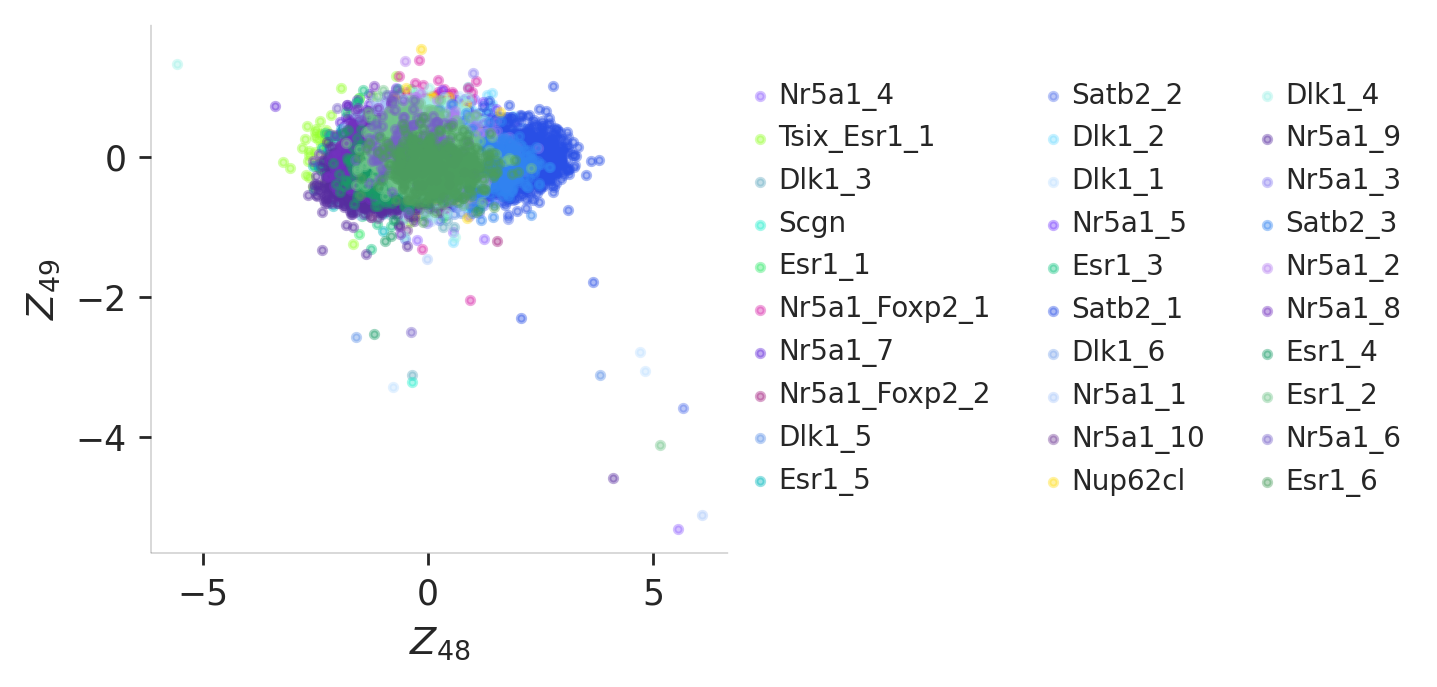

In [ ]:
dims = [[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15],[16,17],[18,19],[20,21],[30,31],[40,41],[48,49]]

for i in dims:
  vis.obj_plot_subembed(latentNCA, allLabs[0],i[0],i[1], fname = 'figs/10XCellTypeDim'+str(i)+'.pdf', colors=clus_colors,figsize=(6,3) ) #vis

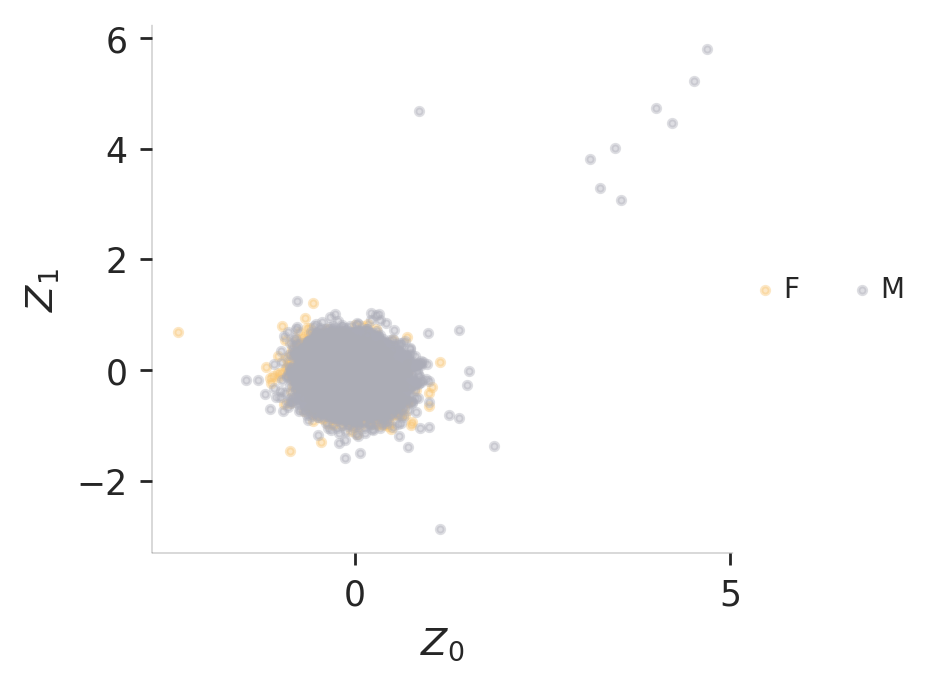

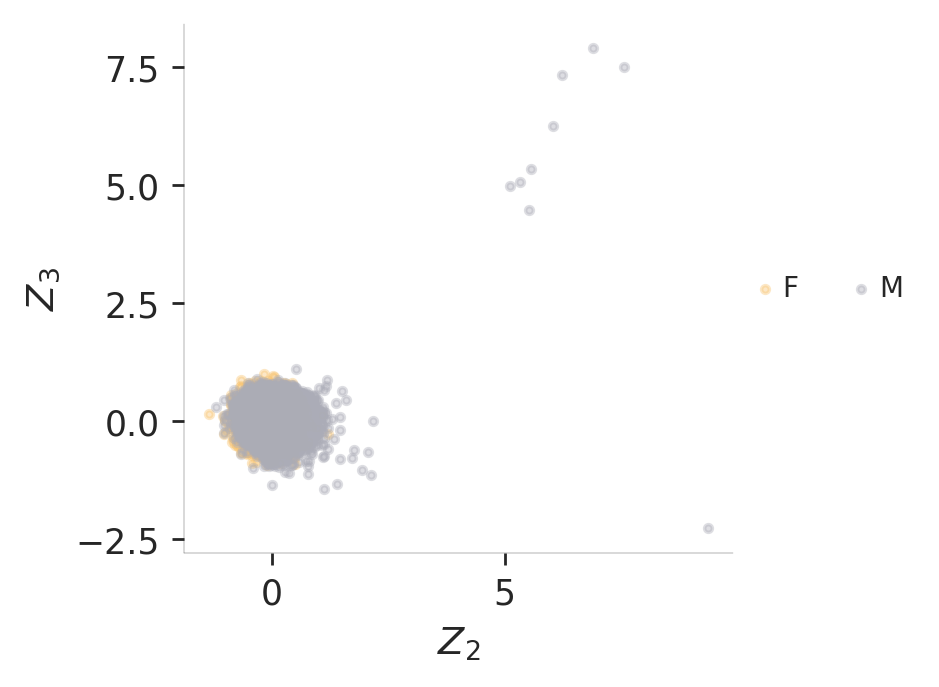

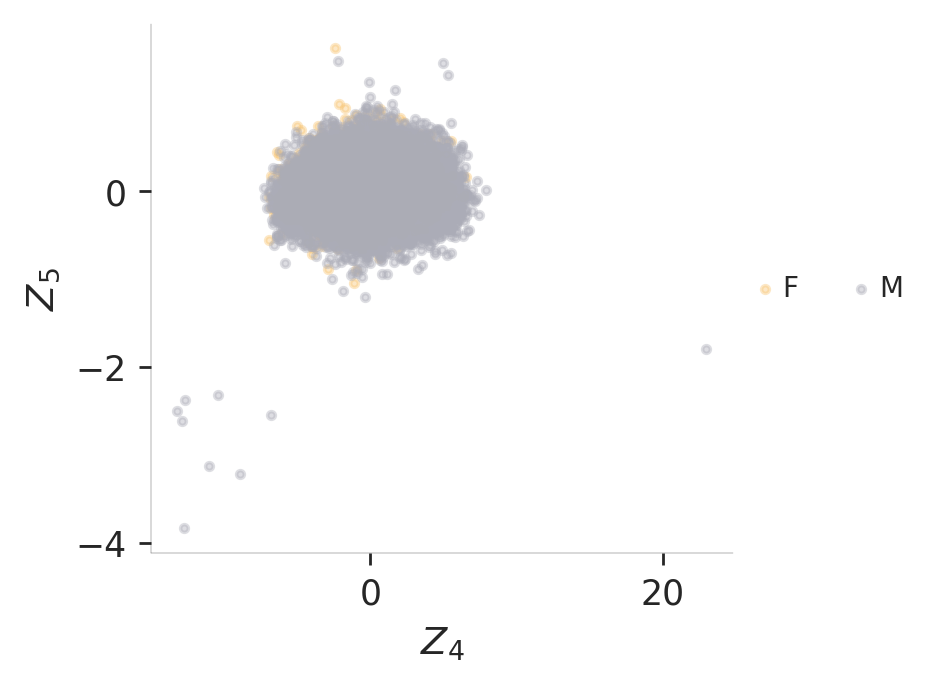

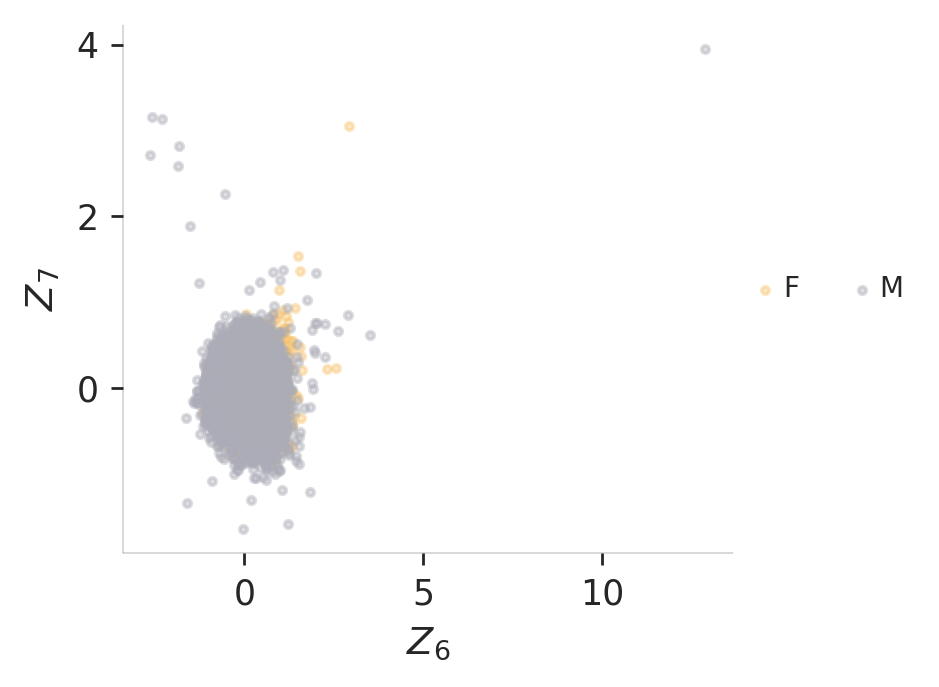

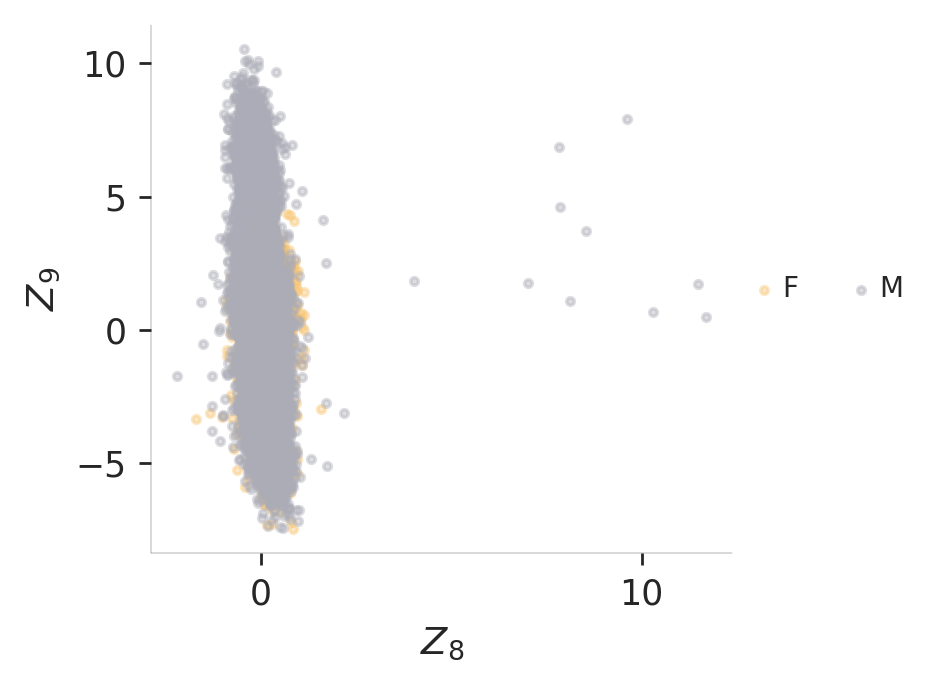

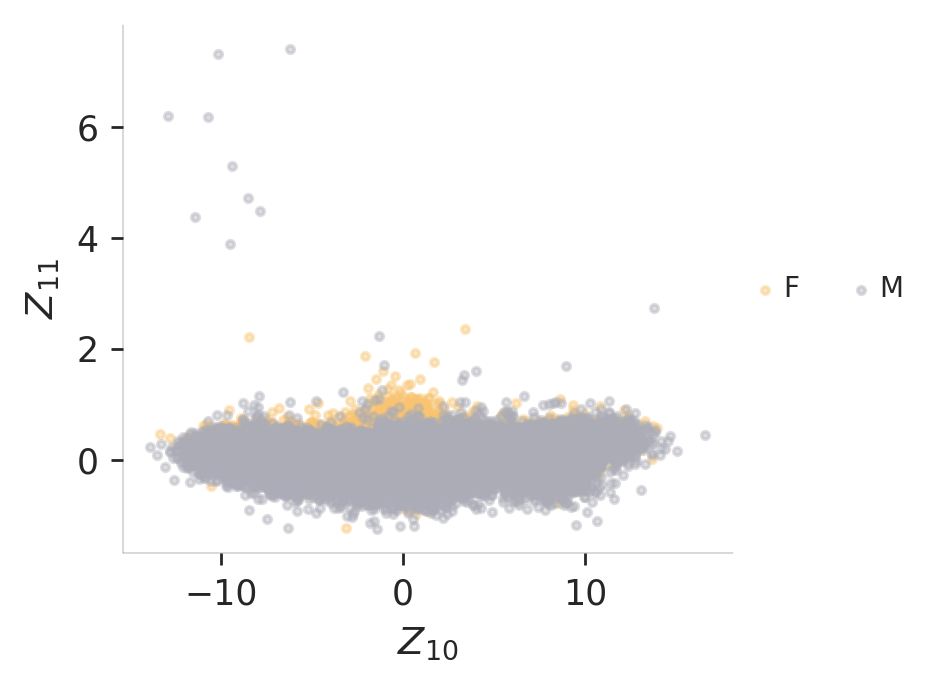

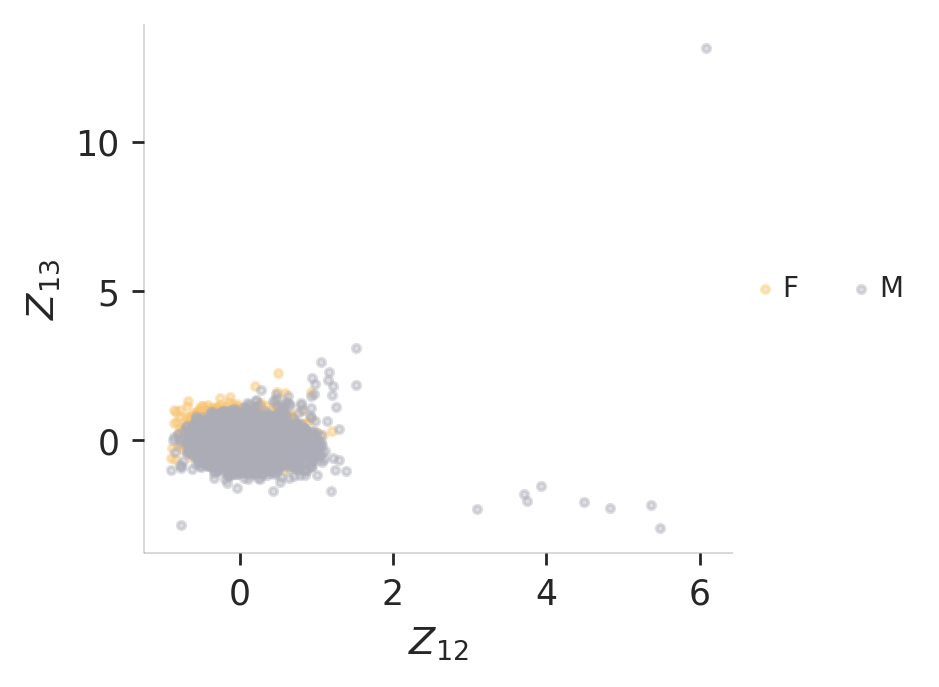

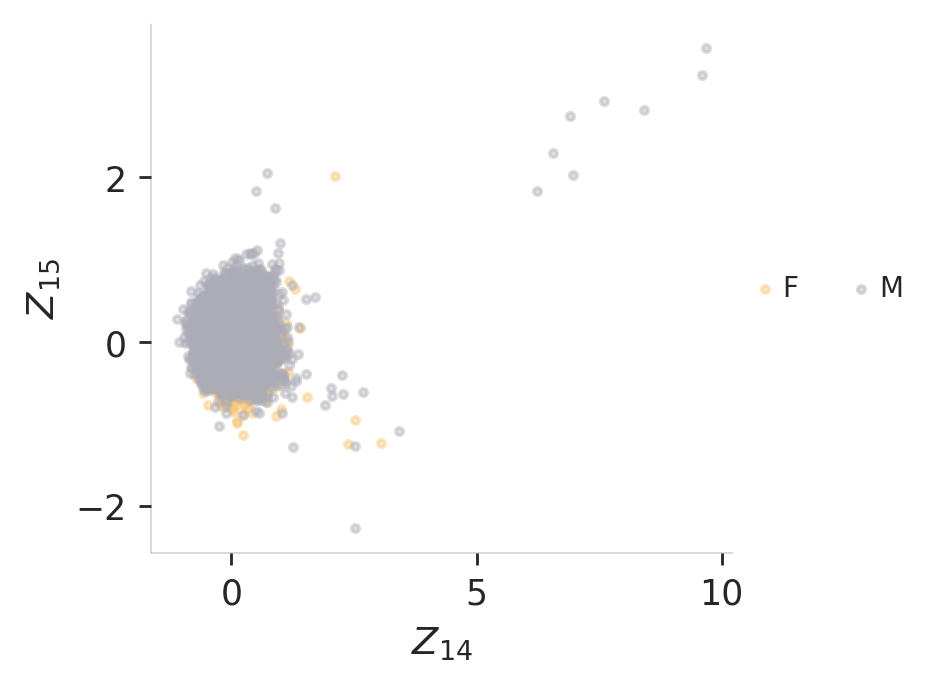

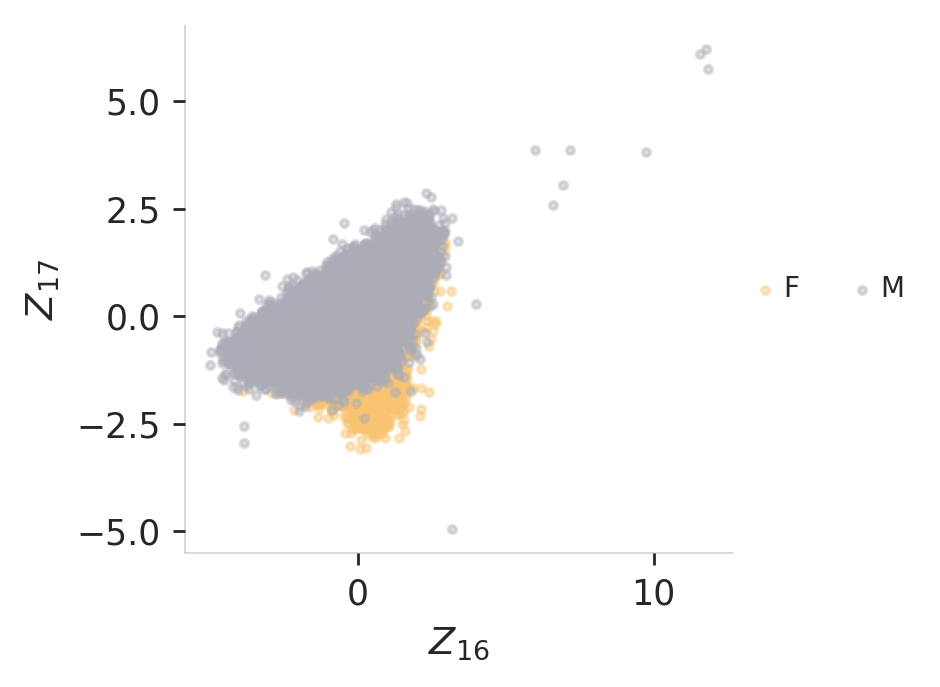

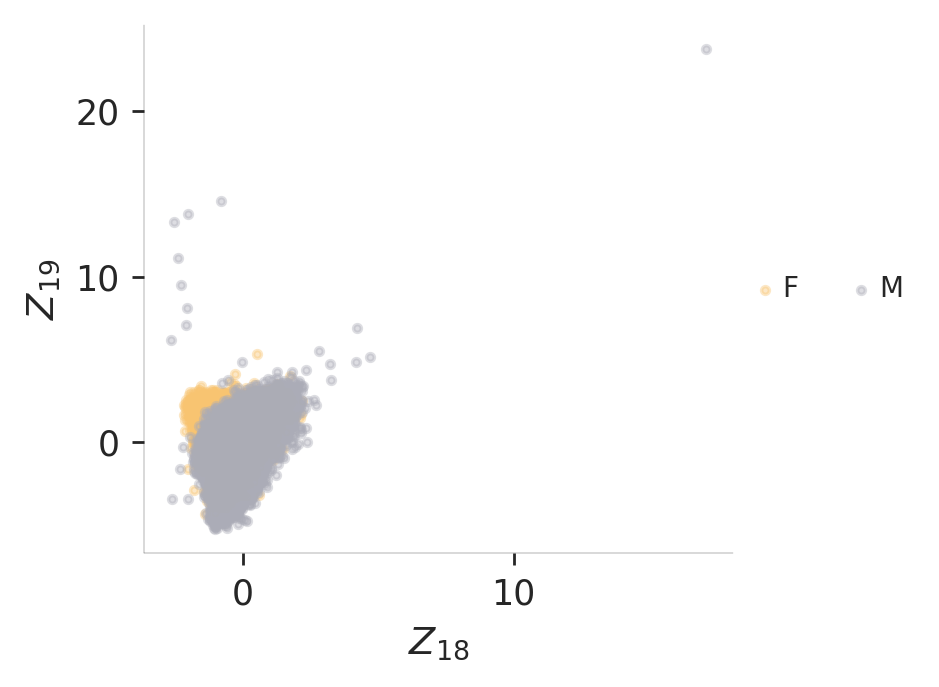

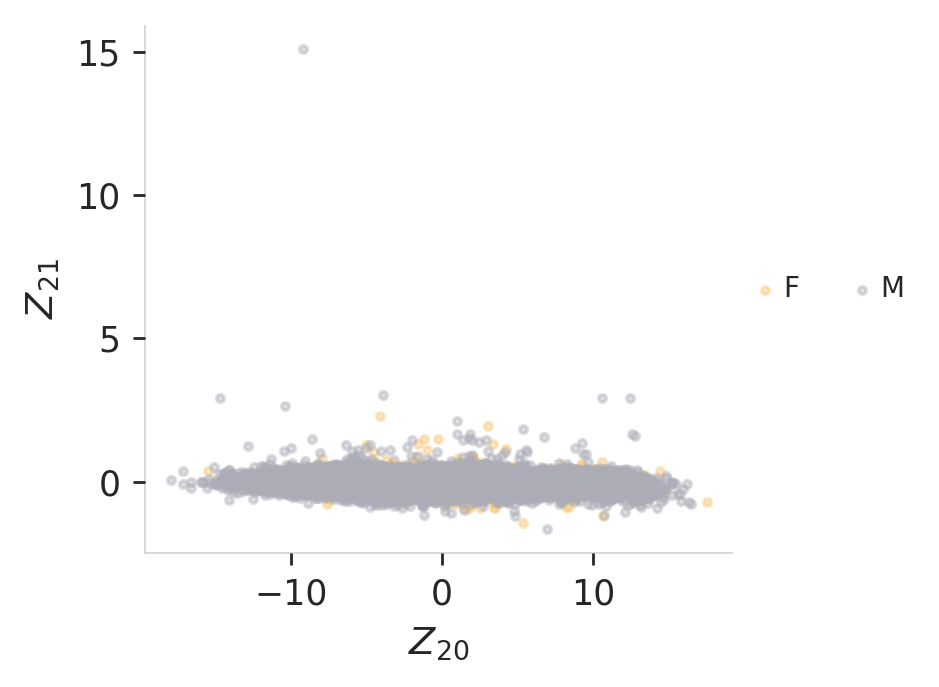

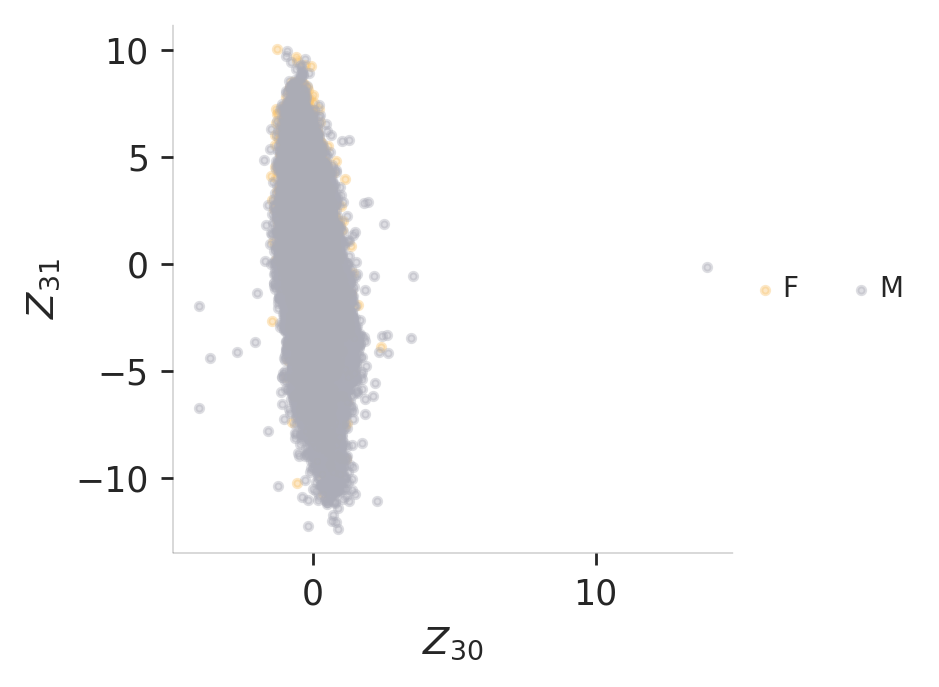

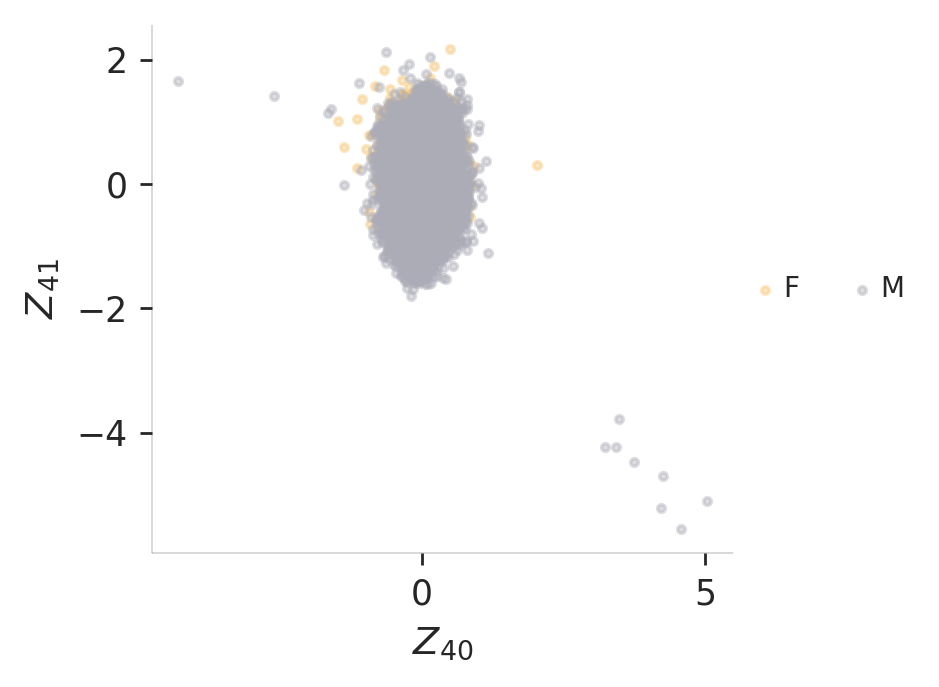

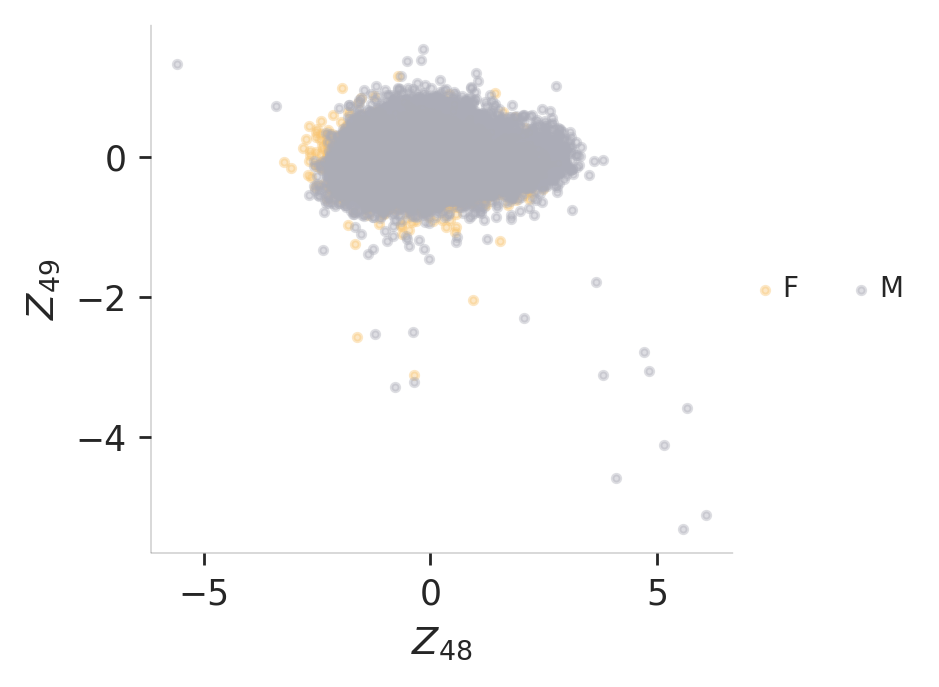

In [ ]:
for i in dims:
  vis.obj_plot_subembed(latentNCA, allLabs[1],i[0],i[1], fname = 'figs/10XSexDim'+str(i)+'.pdf', colors= sex_colors,figsize=(4,3) ) #Plot Sex labels,  vis.

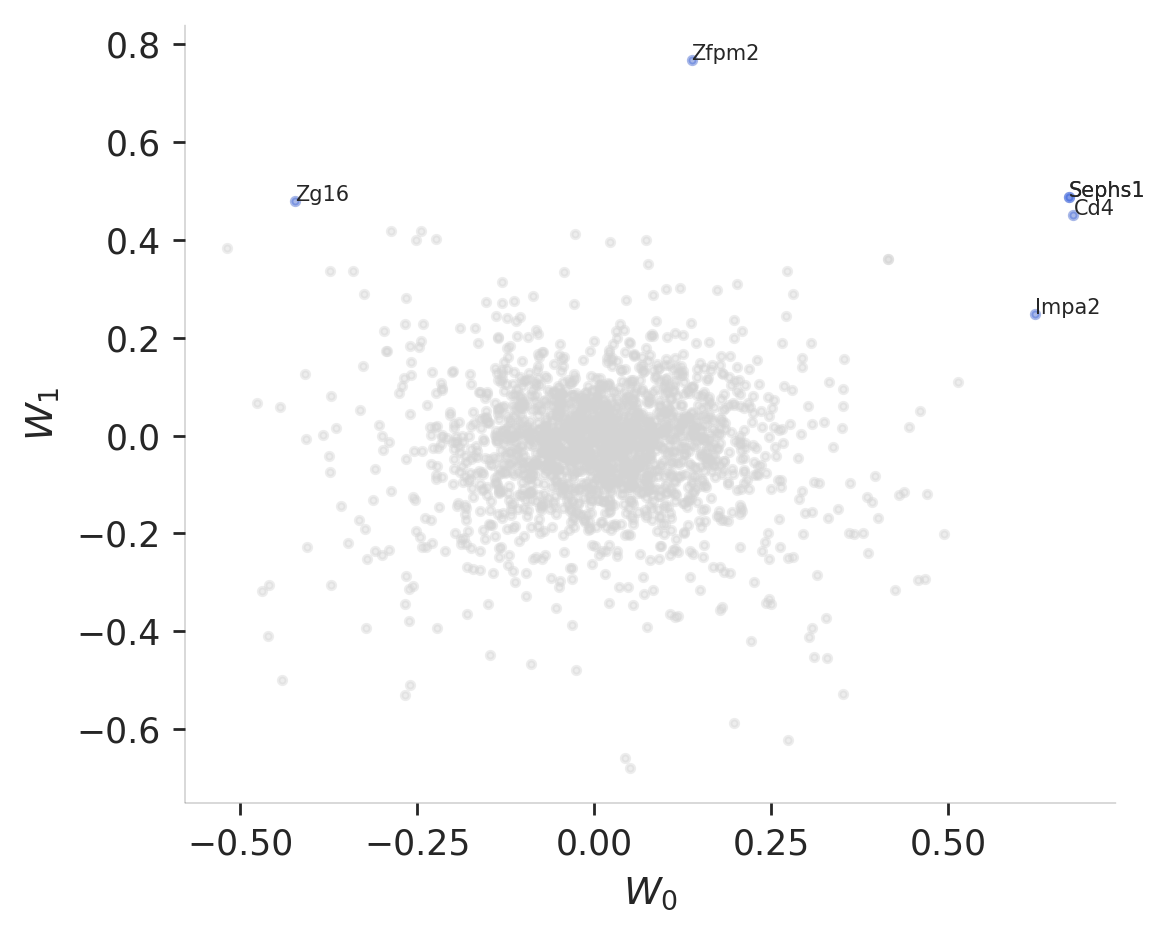

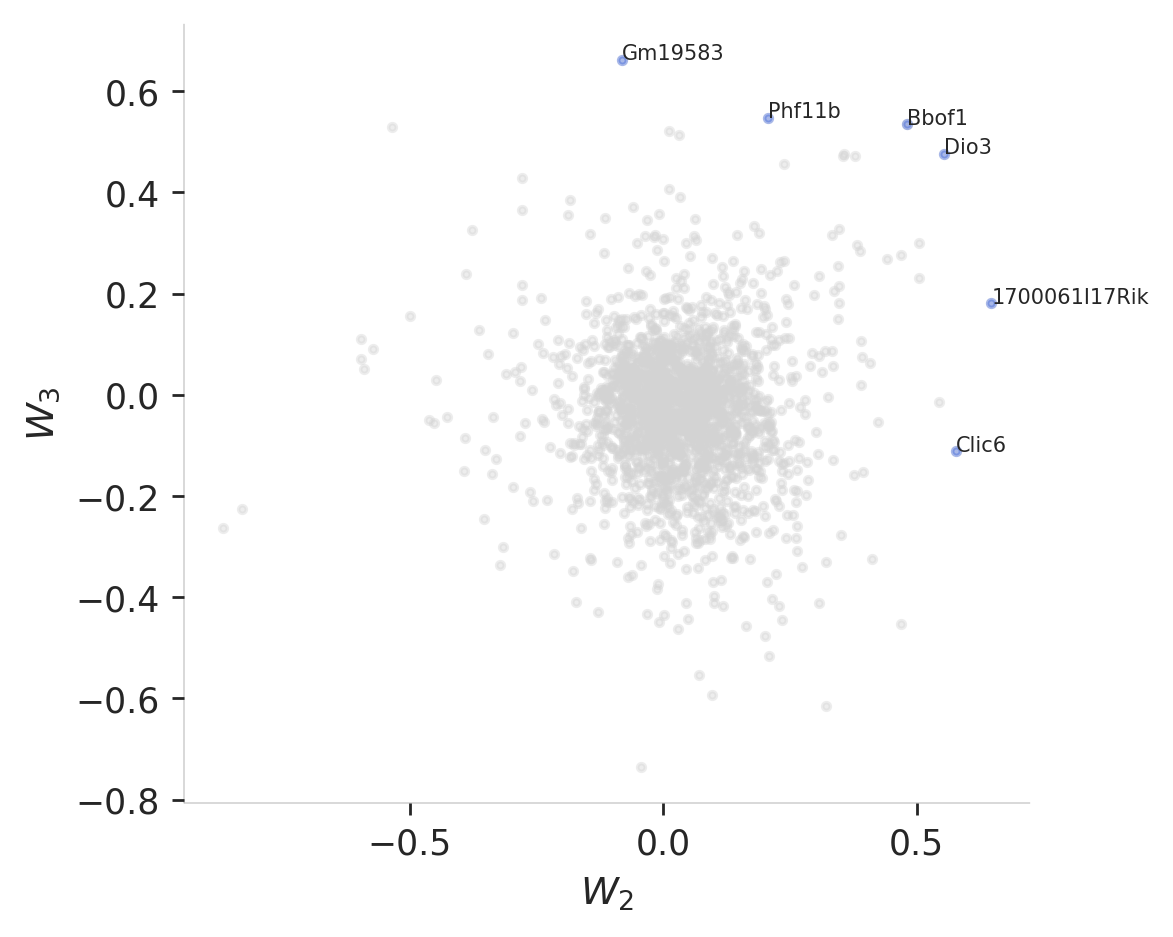

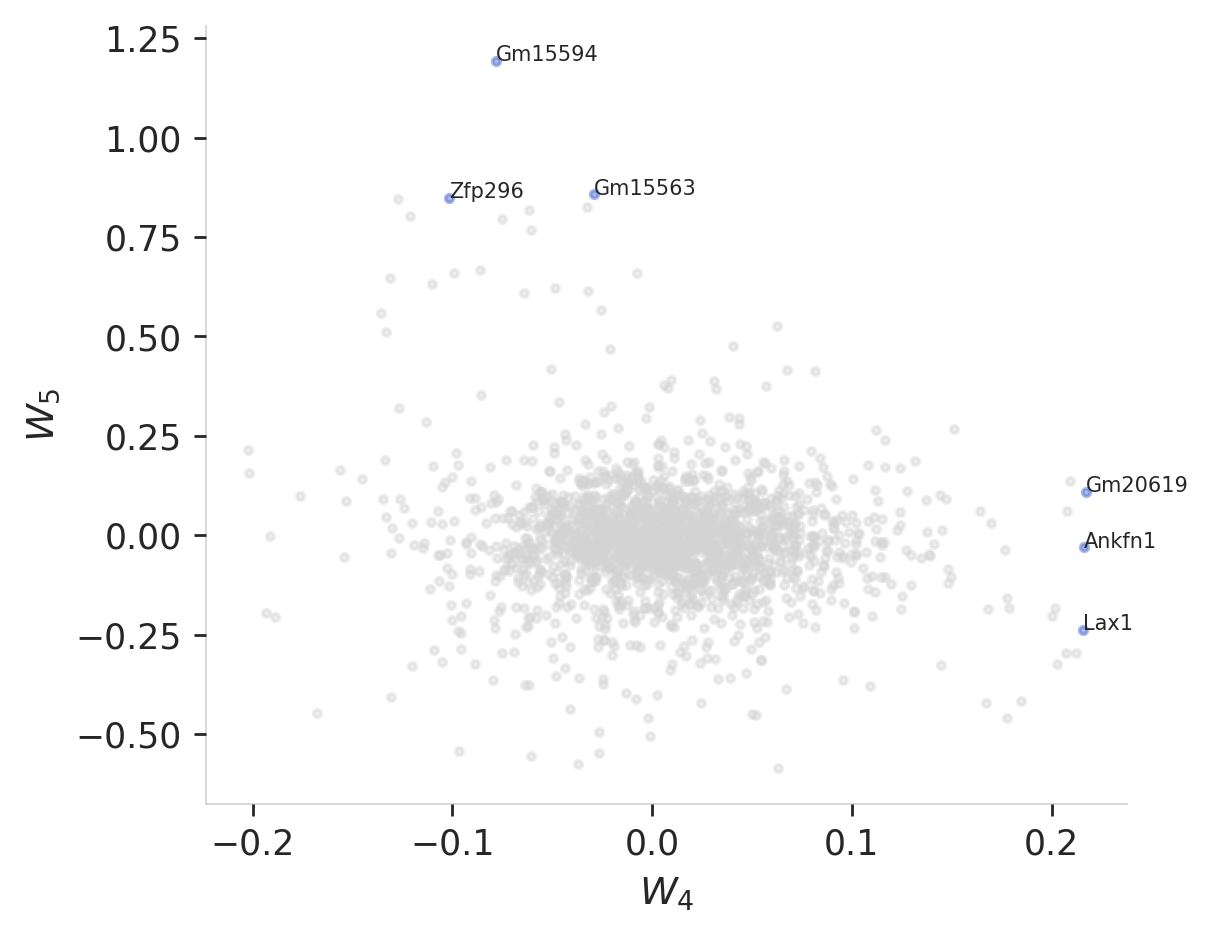

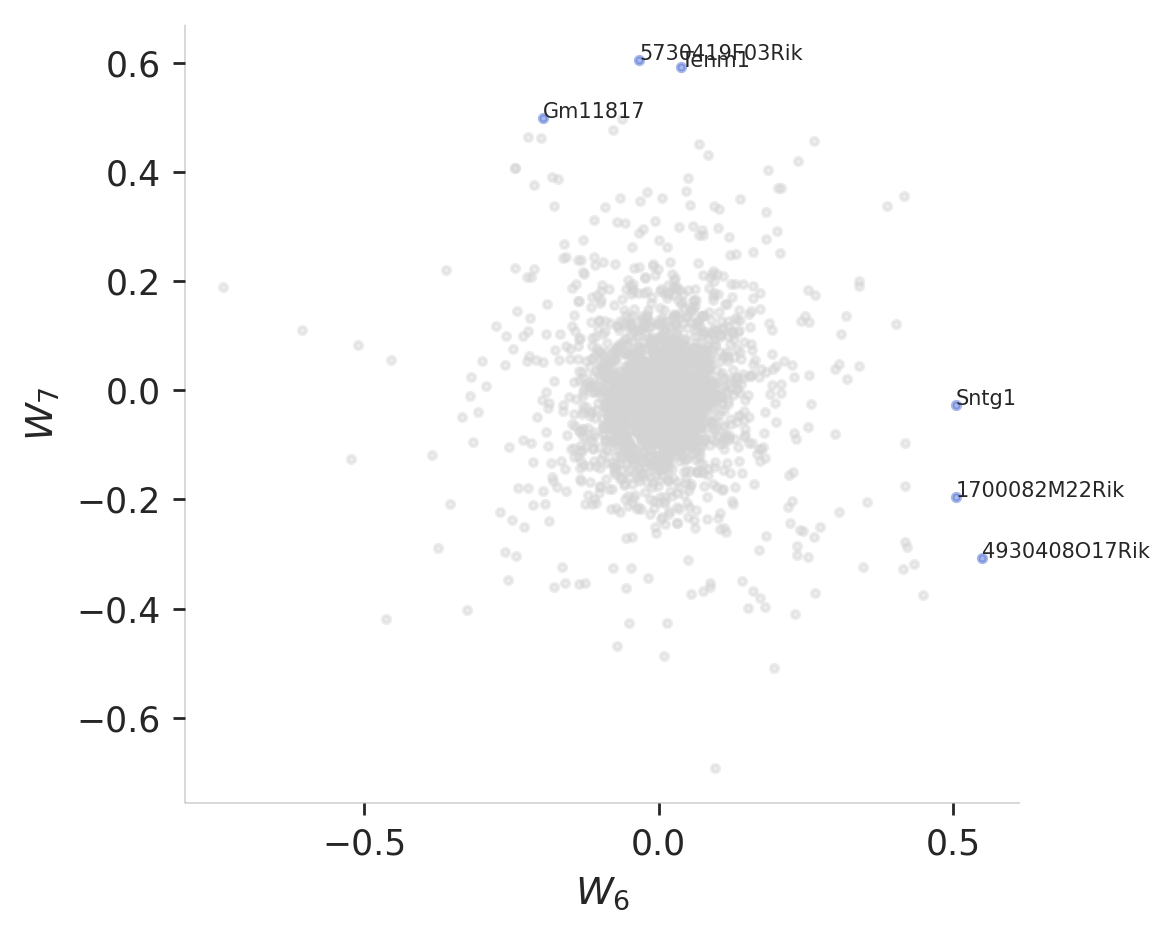

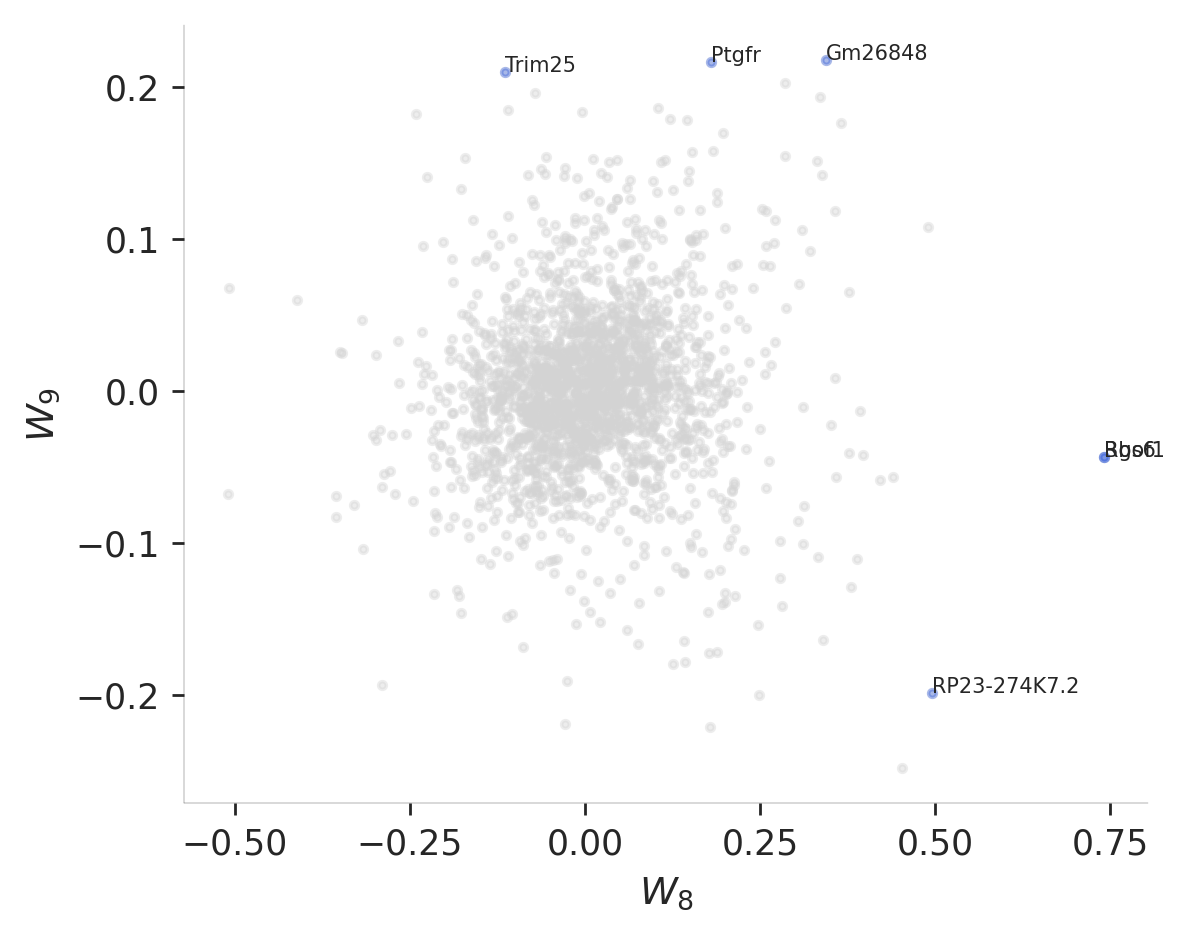

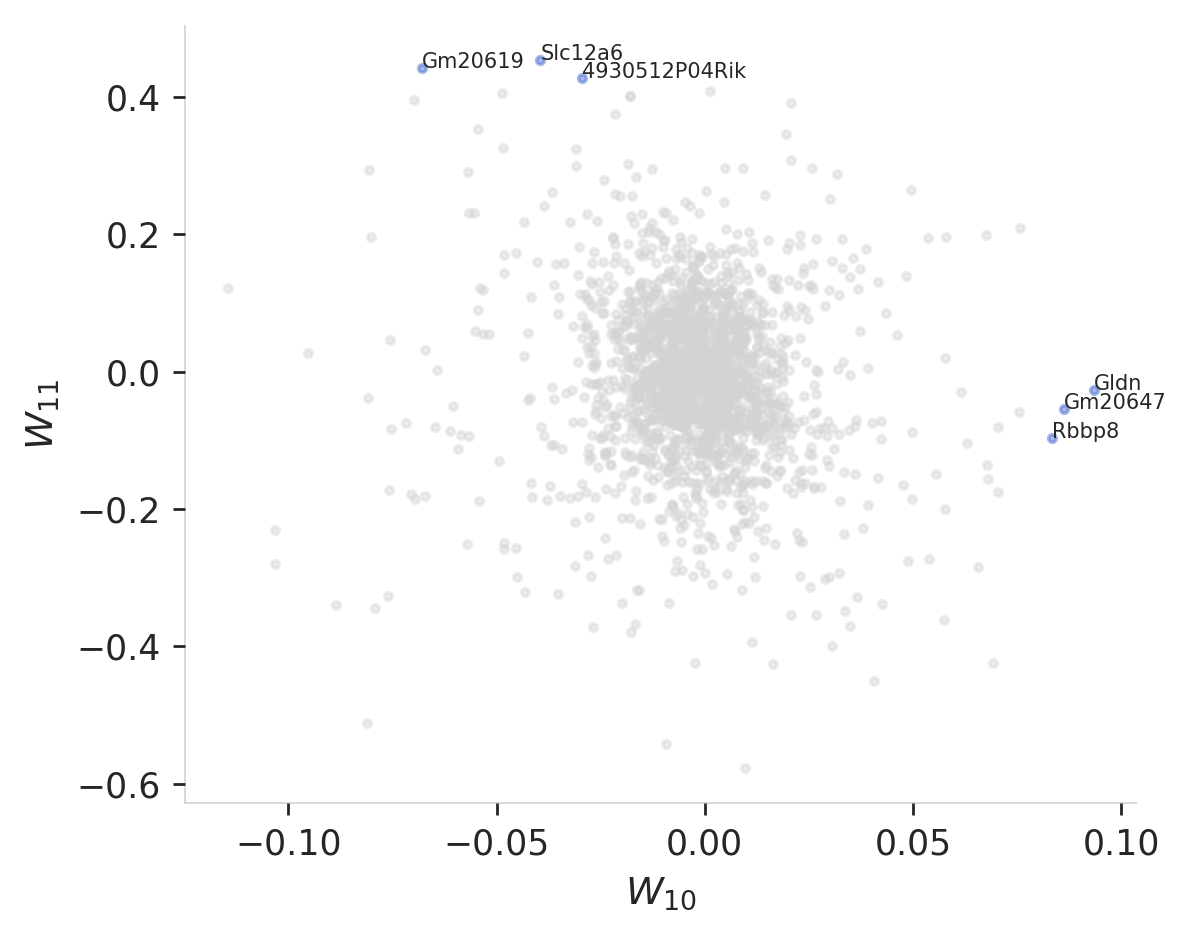

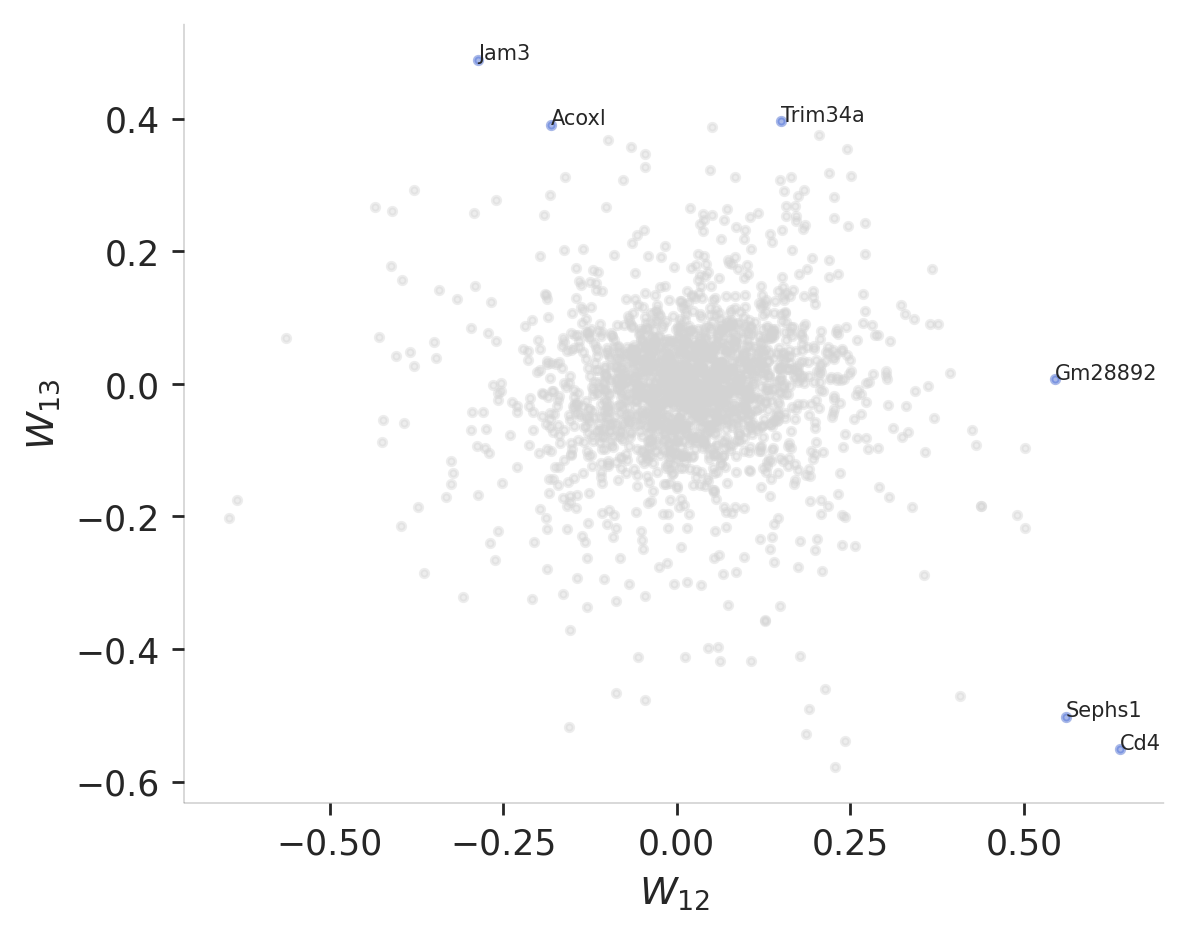

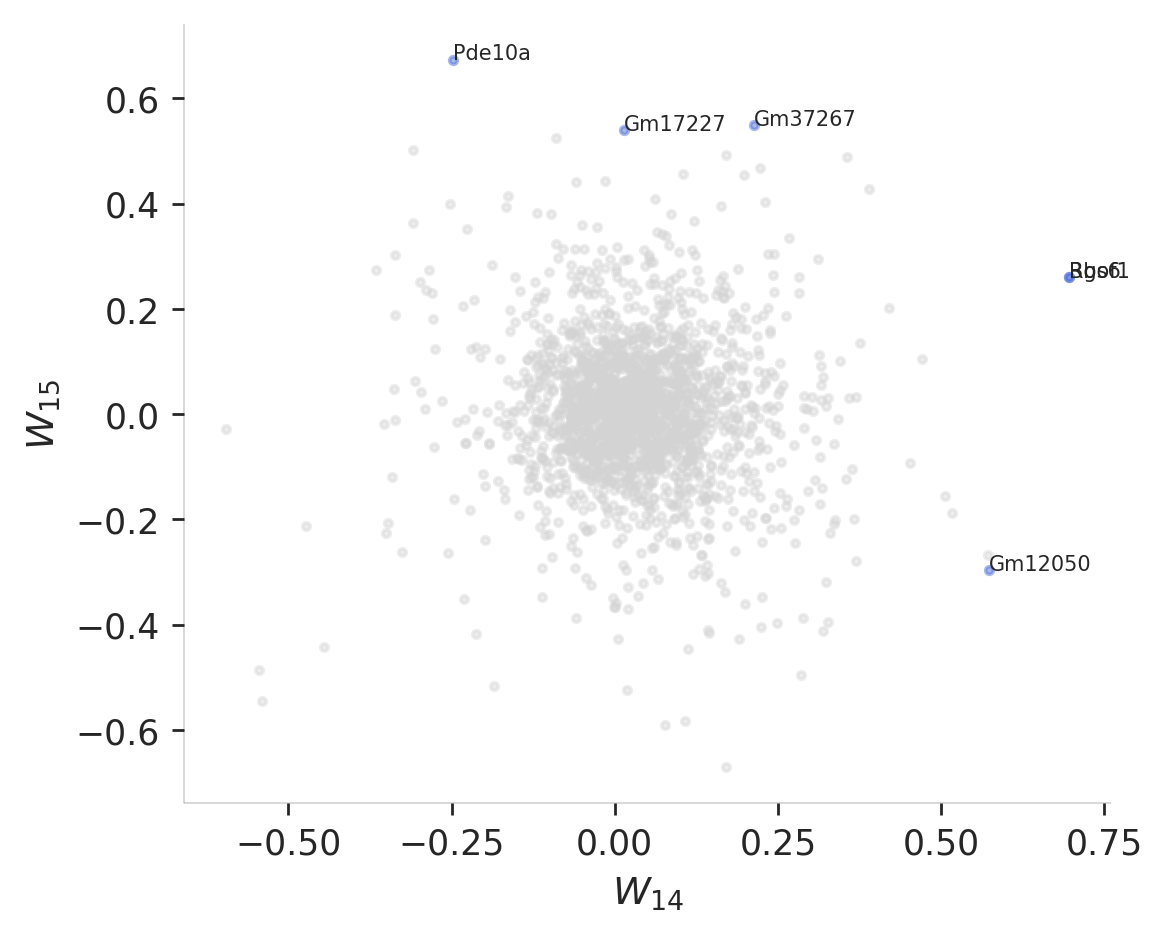

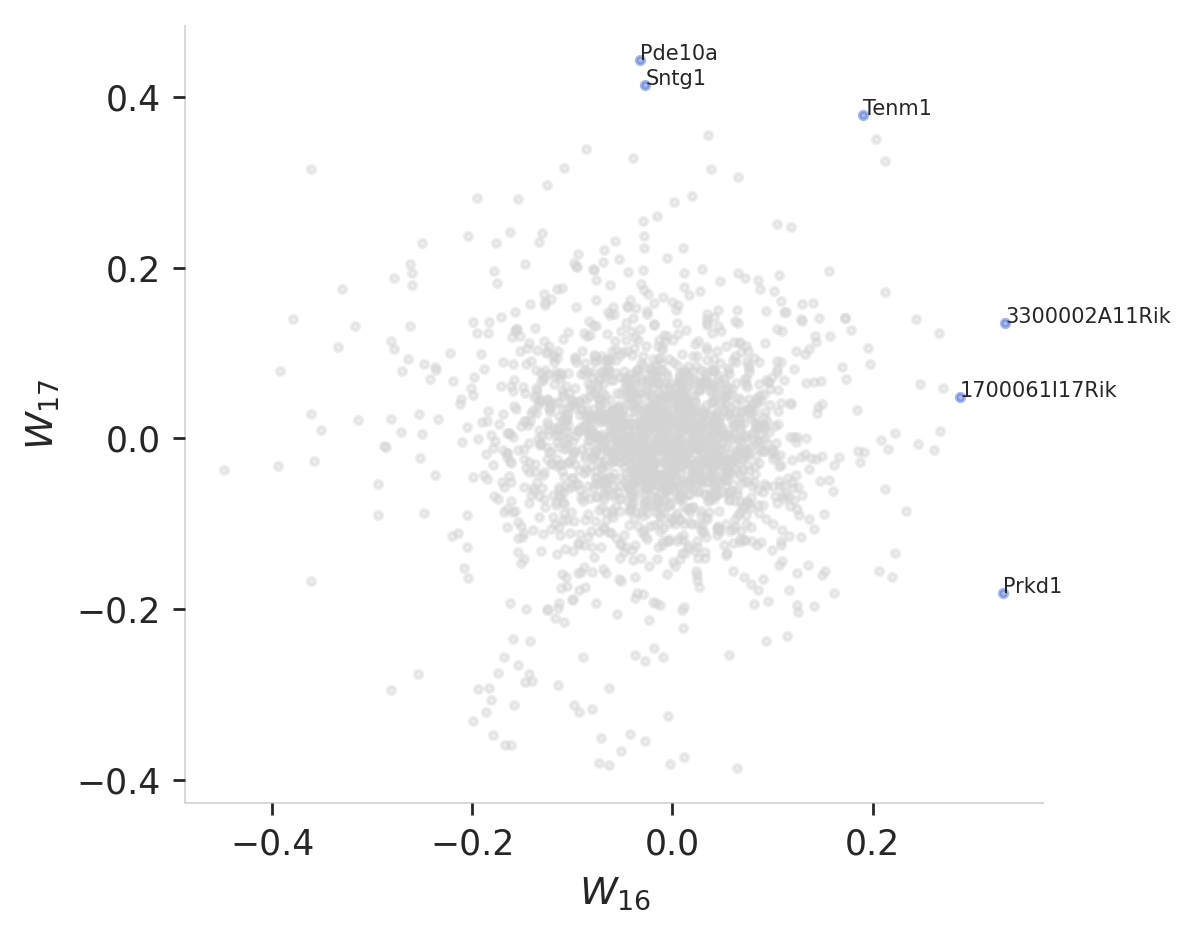

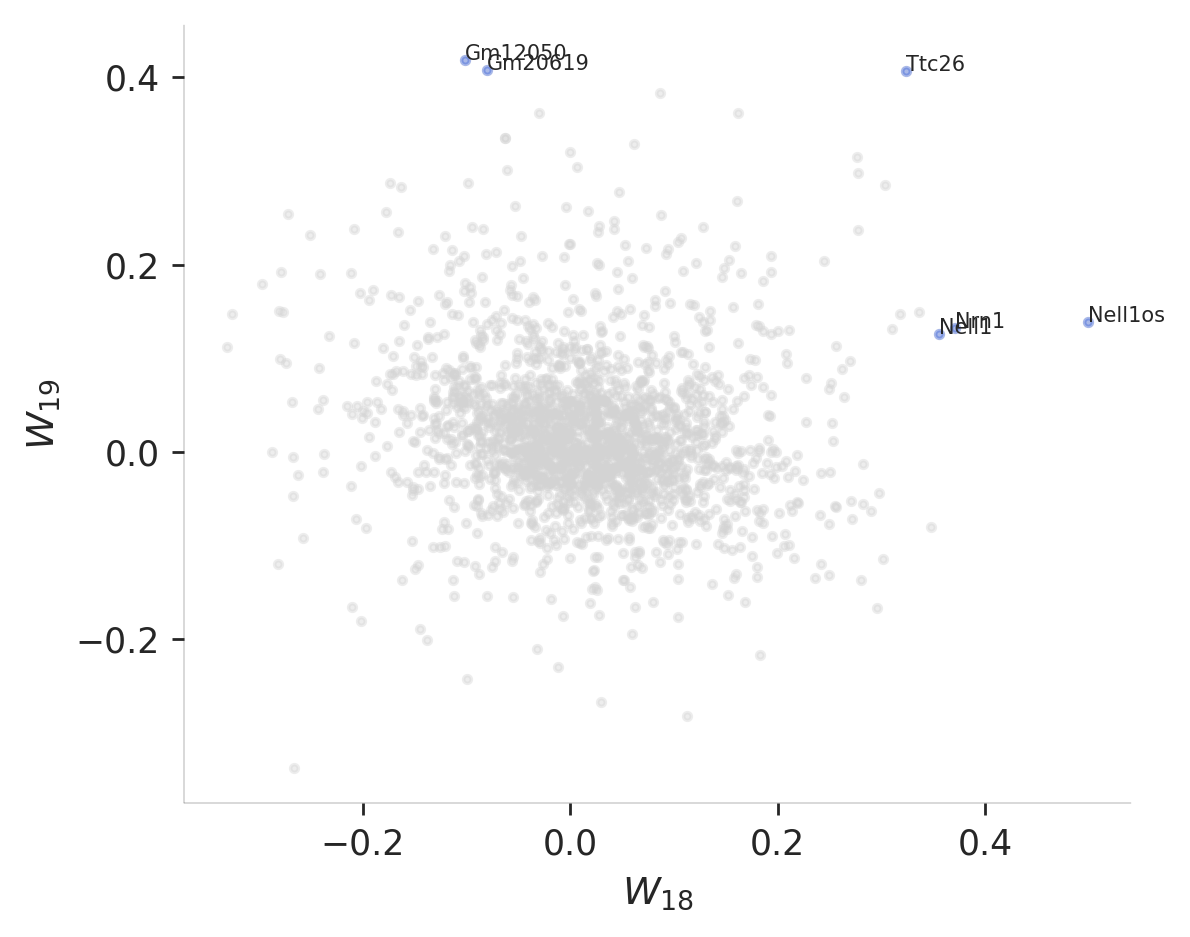

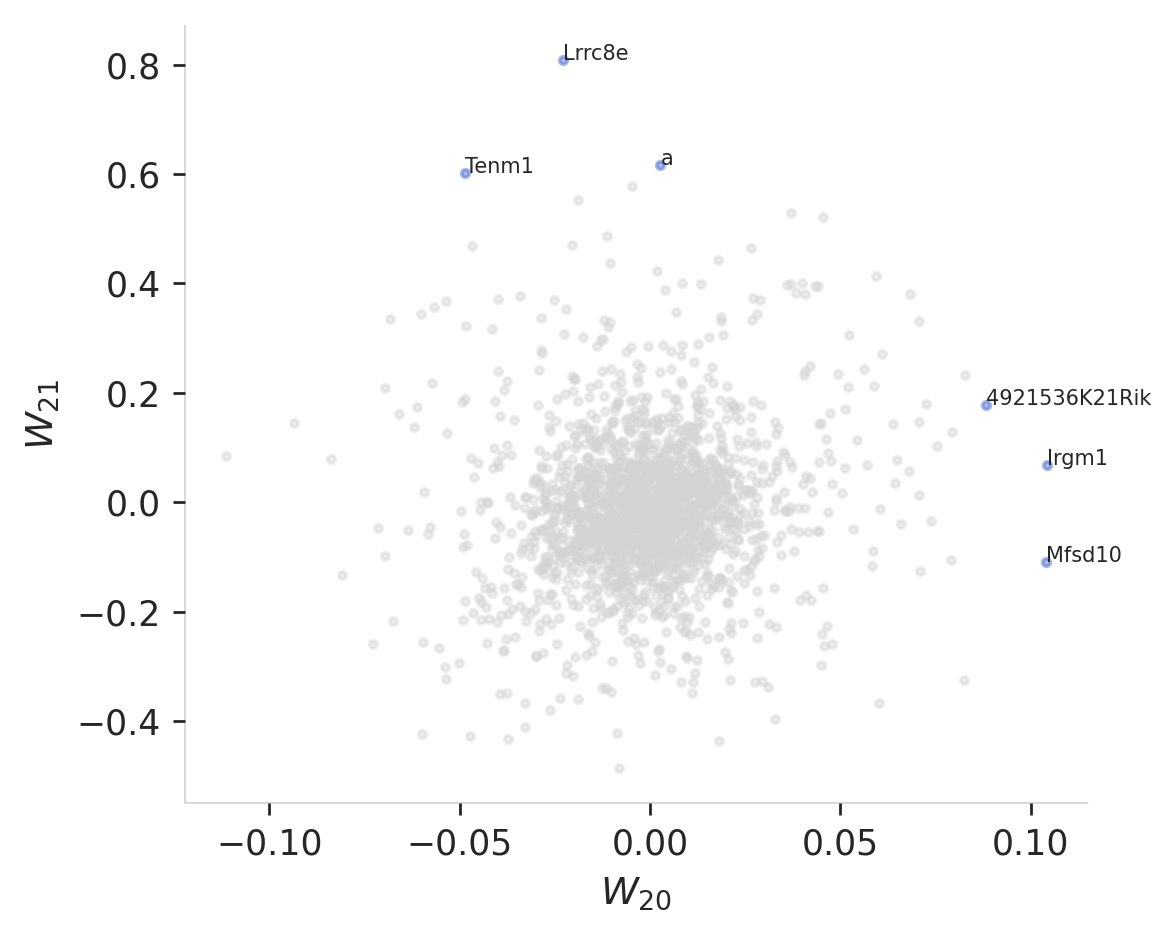

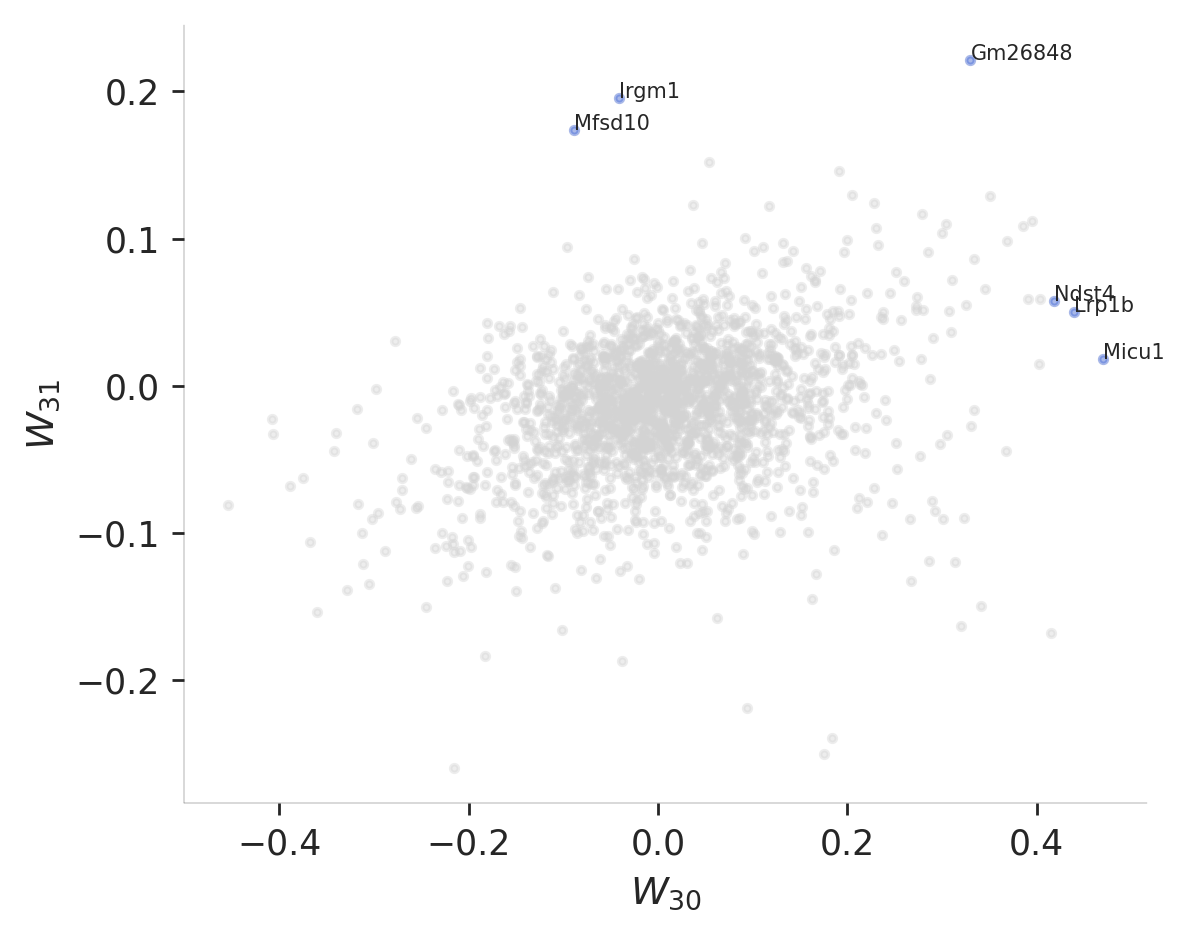

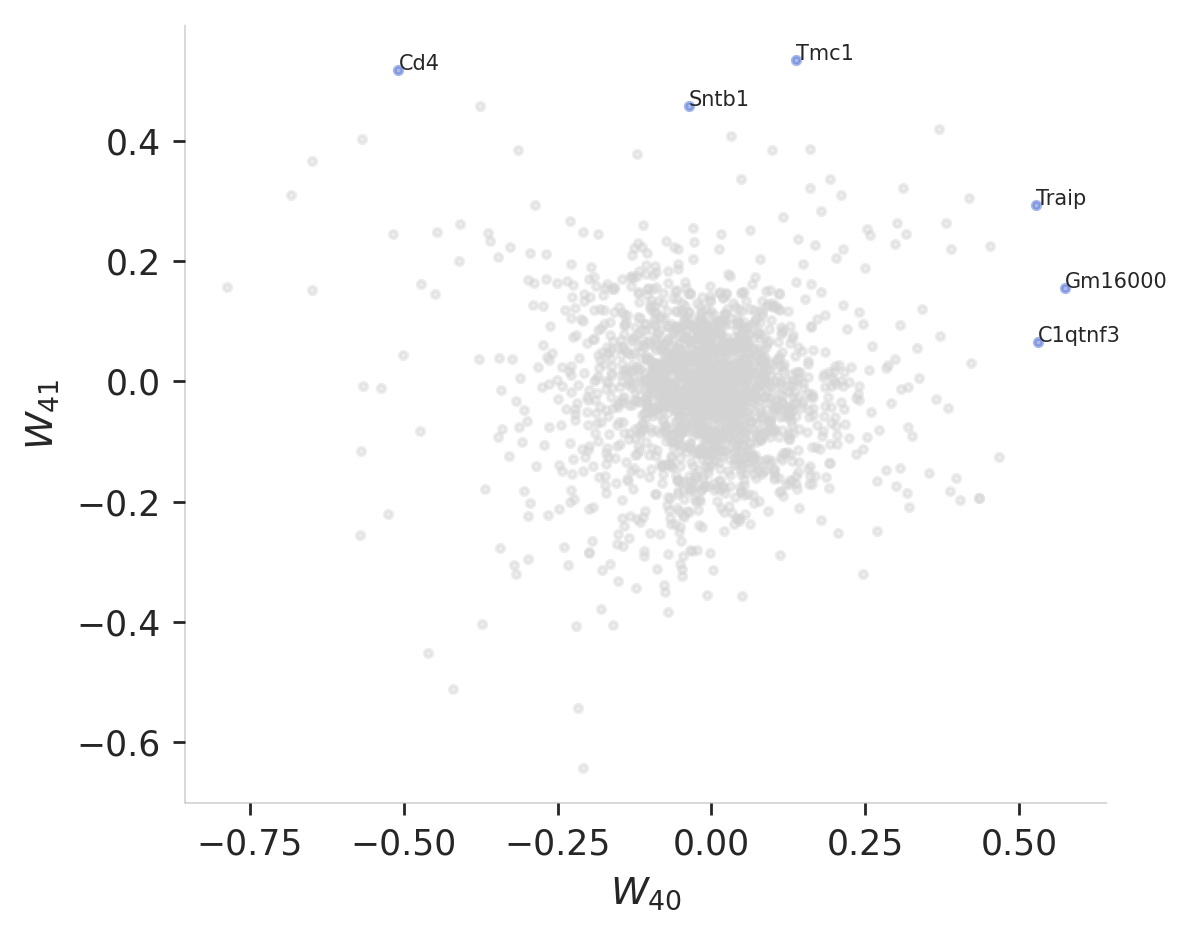

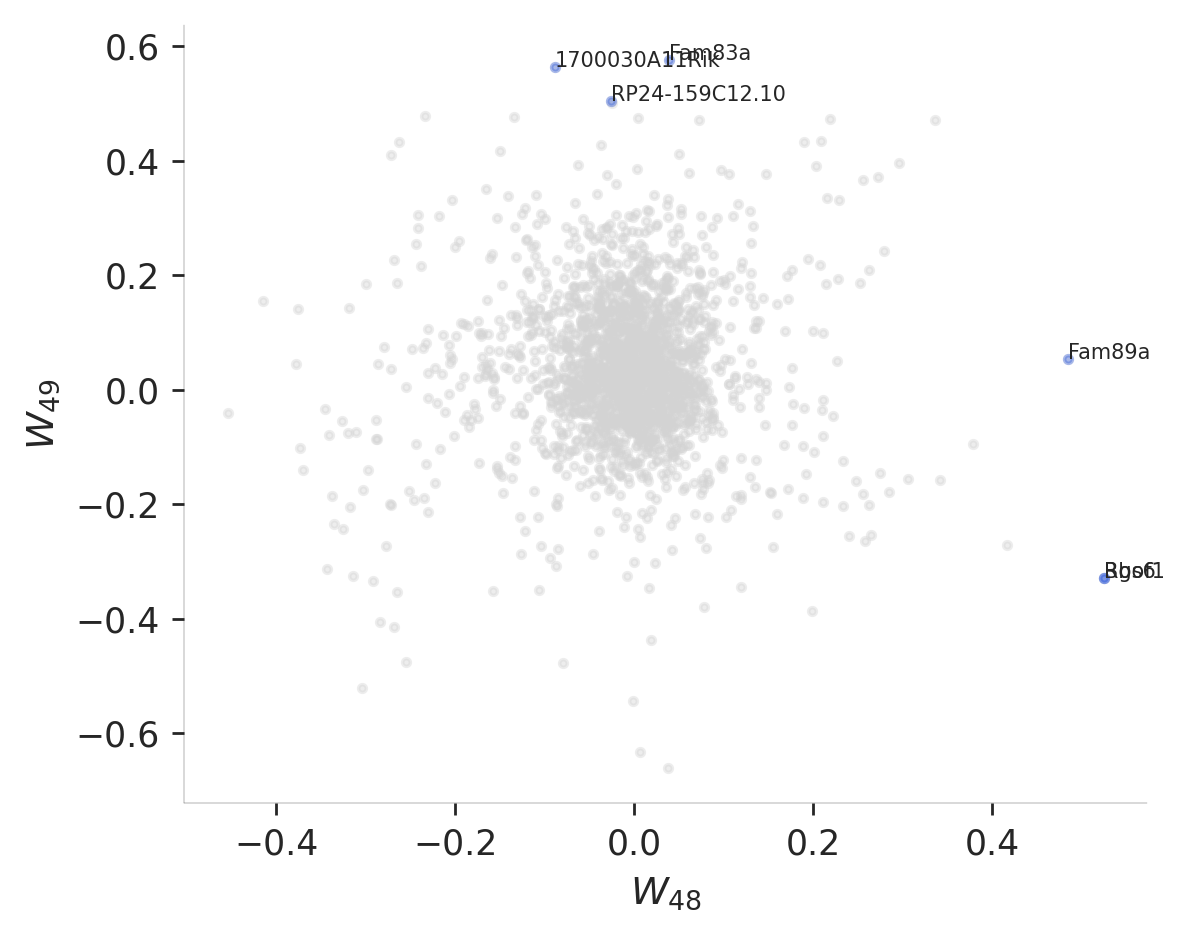

In [ ]:
#Find top 3 in each row, label those point with corresponding genes from list
dims = [[0,1],[2,3],[4,5],[6,7],[8,9],[10,11],[12,13],[14,15],[16,17],[18,19],[20,21],[30,31],[40,41],[48,49]]
for i in dims:
  vis.obj_plot_annot(weight_loadings, genes_names, i[0],i[1], fontsize = 6,fname = 'figs/10XWeightsDim'+str(i)+'.pdf', alpha=0.4, figsize=(5,4)) #vis

In [ ]:
!zip -r figs.zip figs/
!mv figs.zip figsWeights.zip

  adding: figs/ (stored 0%)
  adding: figs/10XCellTypeDim[2, 3].pdf (deflated 2%)
  adding: figs/10XCellTypeDim[48, 49].pdf (deflated 2%)
  adding: figs/10XSexDim[40, 41].pdf (deflated 1%)
  adding: figs/10XCellTypeDim[40, 41].pdf (deflated 2%)
  adding: figs/10XWeightsDim[2, 3].pdf (deflated 12%)
  adding: figs/10XSexDim[20, 21].pdf (deflated 1%)
  adding: figs/10XWeightsDim[0, 1].pdf (deflated 11%)
  adding: figs/10XCellTypeDim[14, 15].pdf (deflated 2%)
  adding: figs/10XWeightsDim[14, 15].pdf (deflated 11%)
  adding: figs/10XWeightsDim[40, 41].pdf (deflated 12%)
  adding: figs/10XWeightsDim[48, 49].pdf (deflated 12%)
  adding: figs/10XWeightsDim[30, 31].pdf (deflated 12%)
  adding: figs/10XCellTypeDim[4, 5].pdf (deflated 2%)
  adding: figs/10XCellTypeDim[10, 11].pdf (deflated 2%)
  adding: figs/10XWeightsDim[10, 11].pdf (deflated 12%)
  adding: figs/10XCellTypeDim[8, 9].pdf (deflated 2%)
  adding: figs/10XWeightsDim[8, 9].pdf (deflated 12%)
  adding: figs/10XWeightsDim[6, 7].pdf (de

In [ ]:
from google.colab import files


files.download('figsWeights.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**Biased Reconstruction MCML**

In [ ]:
rounds = 3

In [ ]:
#Test with only sex labels (intra-var for sex)
gen = []
genLab = []
genType = []


for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 100,batch_size = 400) #400
  lossesGen, latentGen = nca.fit(scaled_mat,allLabs[0],allLabs[1], silent=True,ret_loss=True)

  gen += [latentGen]
  genLab += ['Intra-Sex MCML']
  genType += ['MCML 50D']



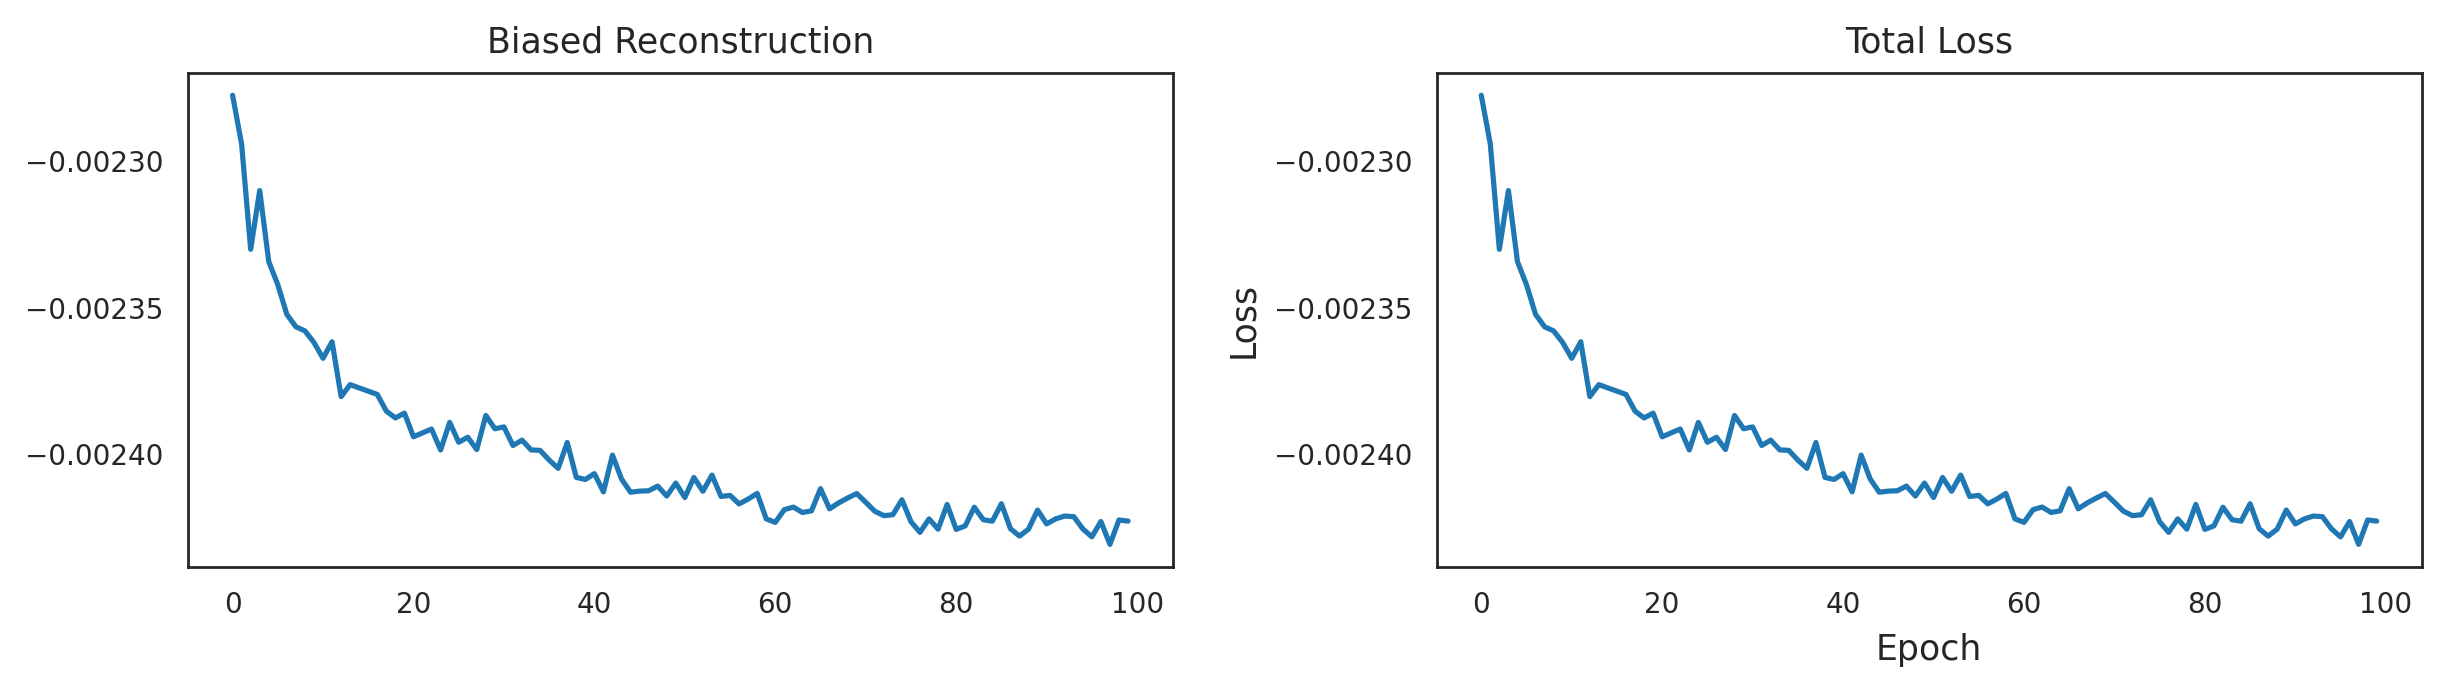

In [ ]:
#Sex loss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

In [ ]:
#Test with only type labels (intra-var for type)
typ = []
typLab = []
typType = []

for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 100, batch_size = 400)
  lossesType, latentType = nca.fit(scaled_mat,allLabs[0],allLabs[0], silent=True,ret_loss=True)

  typ += [latentType]
  typLab += ['Intra-Type MCML']
  typType += ['MCML 50D']



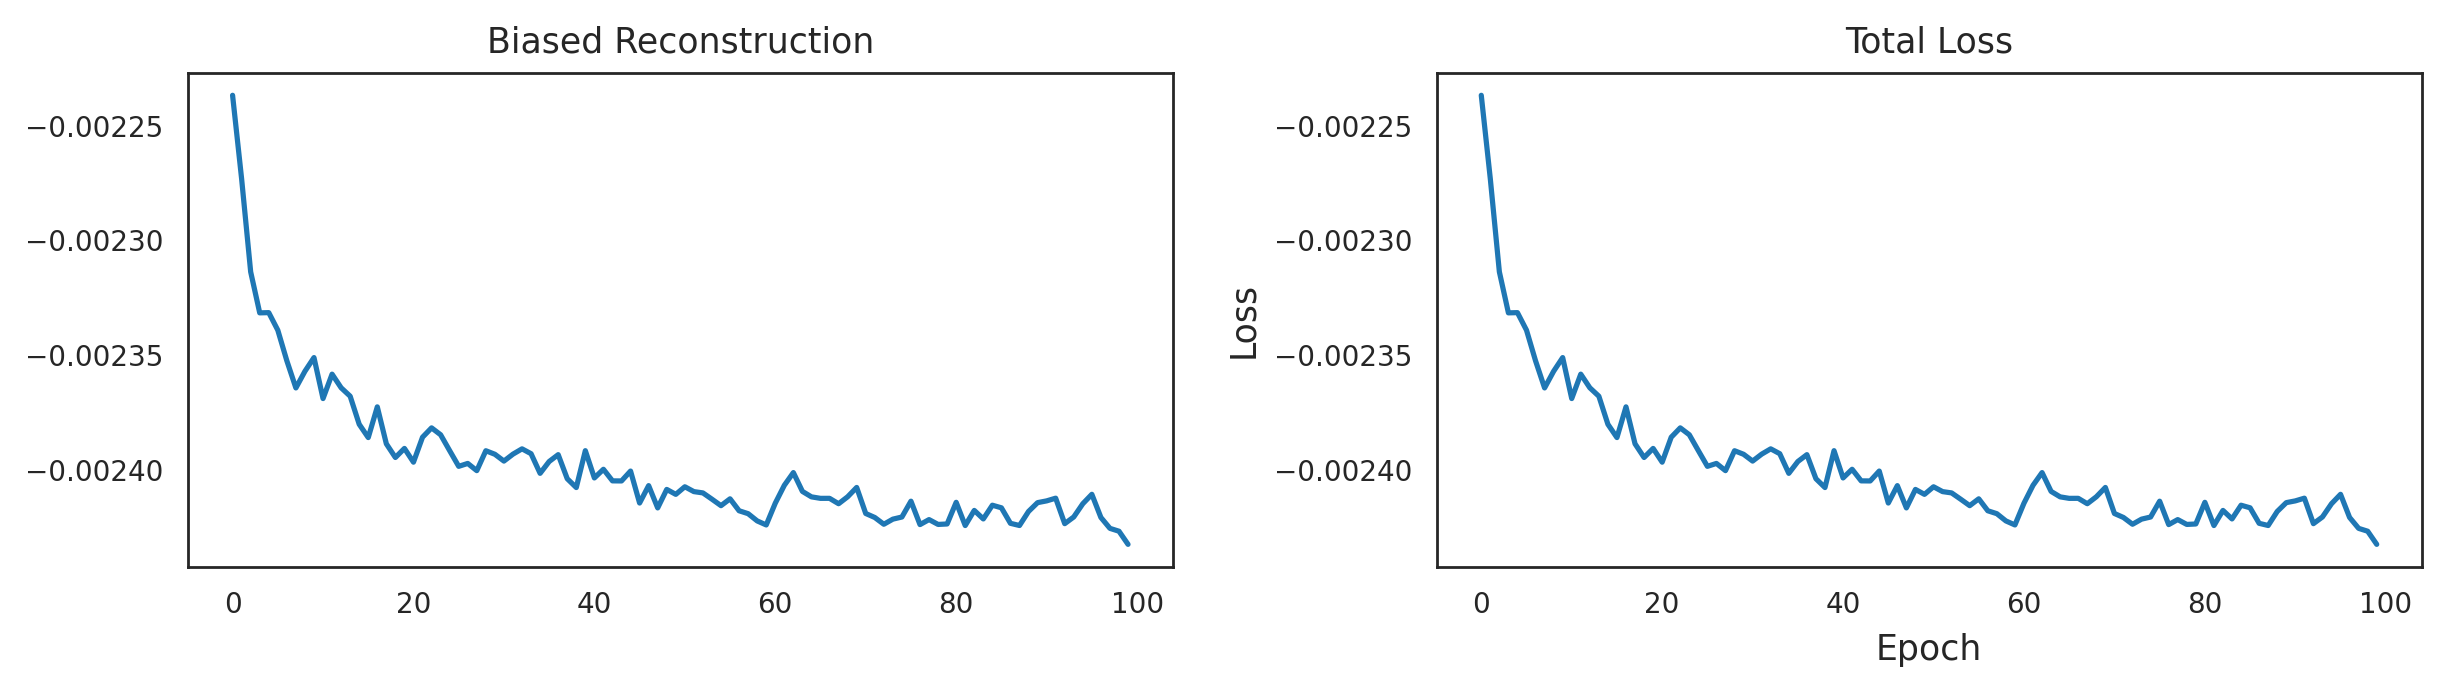

In [ ]:
#Type loss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Get latent spaces for comparison (baselines)

In [ ]:
latents,latentLab,latentType = tl.reconComp(scaled_mat, ndims=2, pcs=50)

Compare gender corr reconstruction accuracy

In [ ]:
latents = gen + latents

latentLab = genLab + latentLab

latentType = genType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['PCA 2D'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
intraSex = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Sex MCML']) & allVals['Distance'].isin(['Intra-Sex'])])

print((intraSex-pca)/pca)
print((intraSex-recon)/recon)

0.3227180403256997
0.2612125459254803


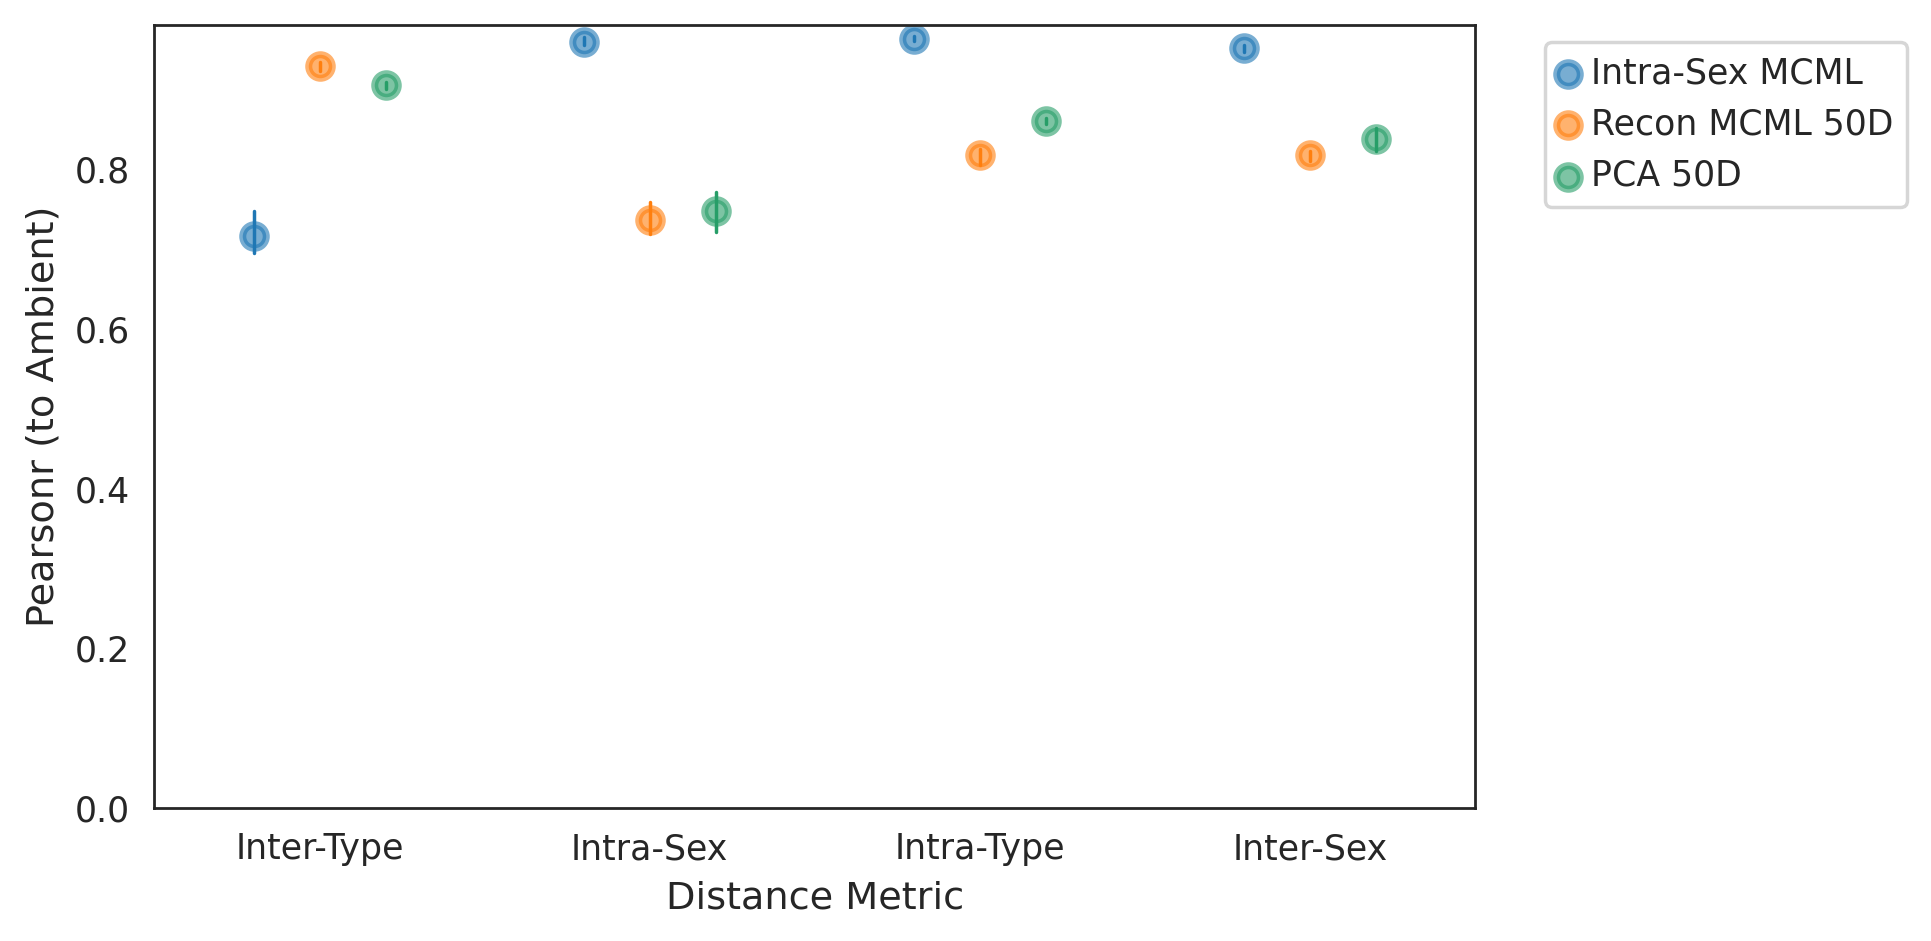

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None)

Compare type corr reconstruction accuracy

In [ ]:
latents = typ + latents

latentLab = typLab + latentLab

latentType = typType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)


In [ ]:
allVals = allVals[~allVals['Latent'].isin(['Intra-Sex MCML','PCA 2D'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Type'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Type'])])
intraType = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Type MCML']) & allVals['Distance'].isin(['Intra-Type'])])

print((intraType-pca)/pca)
print((intraType-recon)/recon)

0.12077426184914507
0.20206293246501122


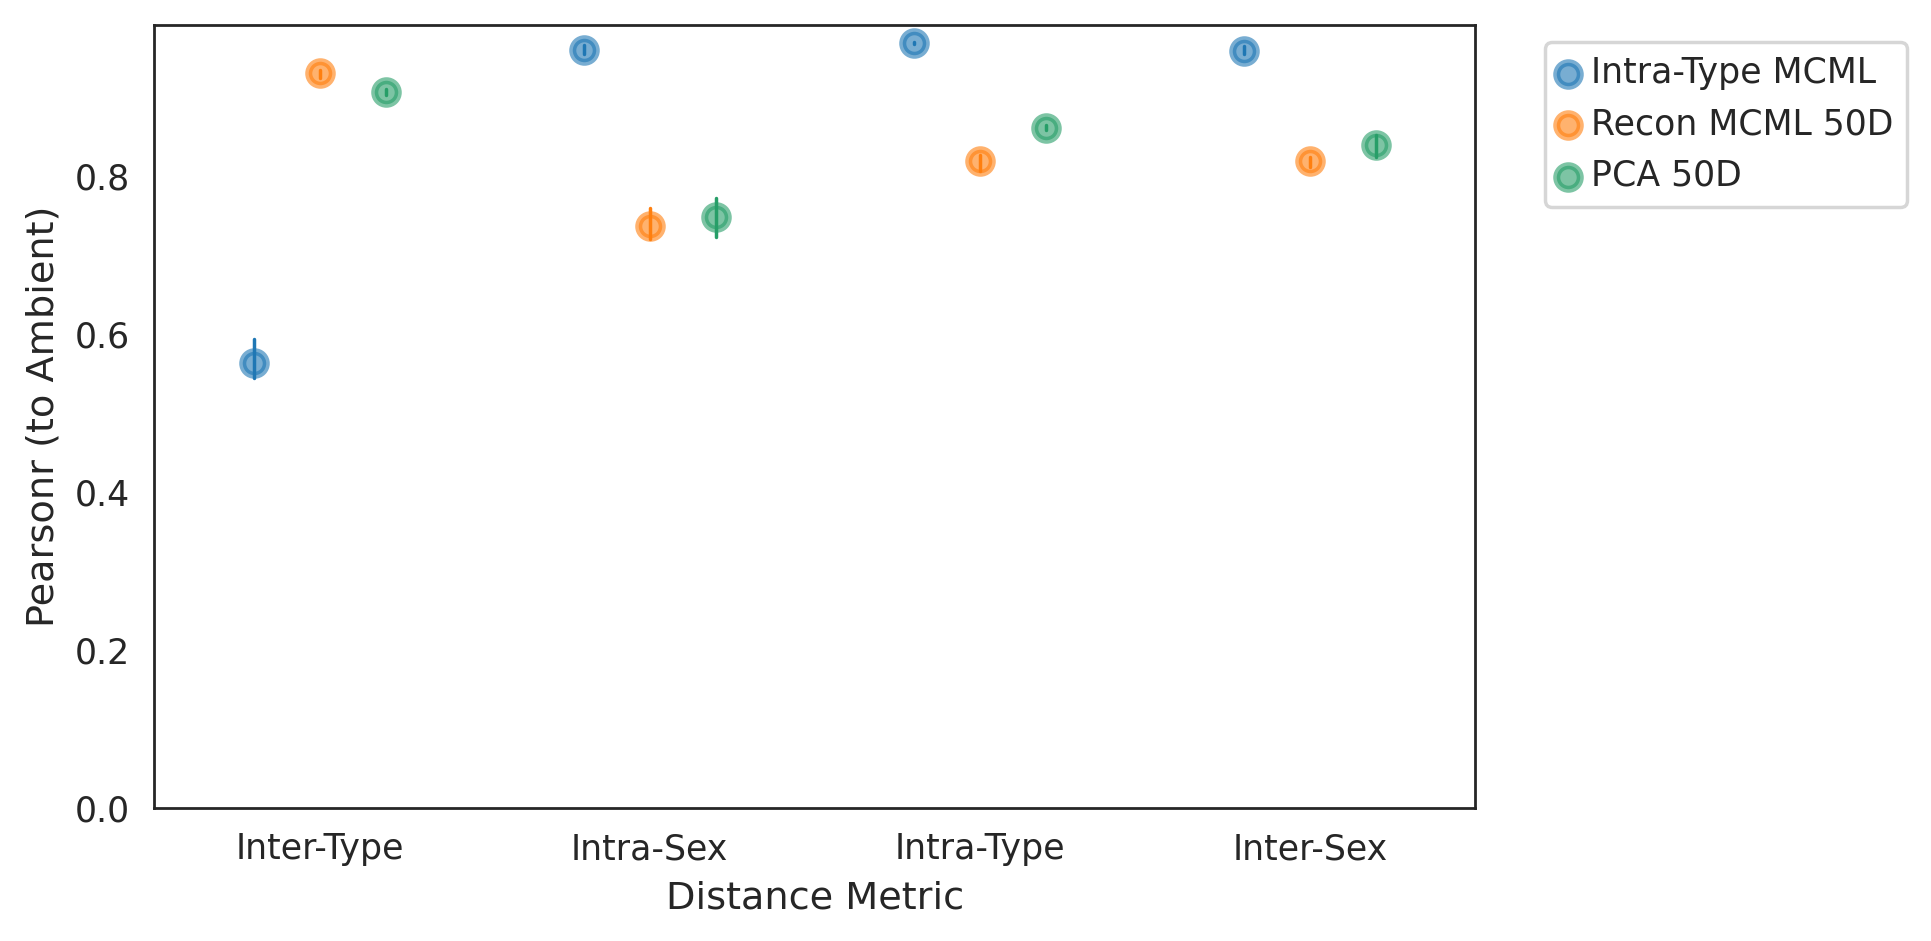

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, fname = None)